# Version 08/12 
- Main Pipeline described with the preprocessing, the models used, the metrics obtained and the visualization
- Compare the features values from T3 and T1 using (T1-T3)/T1, for all patients present in both T1 and T3
- Use of the correlation matrix to remove features
- Connectome features can also added
- More general features (age, gender) can be added

In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import seaborn as sns

# Function to remove the collinear features

In [20]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

# Function to get the connectomes data

In [21]:
def get_common_patients(path_T1, path_T3):
    """
    Identifies common patients in T1 and T3 datasets.
    Args:
        path_T1 (str): Directory path for T1 connectomes.
        path_T3 (str): Directory path for T3 connectomes.
    Returns:
        set: Set of patient IDs common to both T1 and T3.
    """
    patients_T1 = set([f.split("_")[0] for f in os.listdir(path_T1) if f.endswith(".csv")])
    patients_T3 = set([f.split("_")[0] for f in os.listdir(path_T3) if f.endswith(".csv")])
    return patients_T1.intersection(patients_T3)

In [22]:
def process_connectomes(path_dir, common_patients):
    """
    Processes connectomes and filters for common patients.
    Args:
        path_dir (str): Directory path for connectomes.
        common_patients (set): Set of common patient IDs.
    Returns:
        dict: Dictionary with patient IDs as keys and flattened connectomes as values.
    """
    patient_connectomes = {}
    for f in os.listdir(path_dir):
        if f.endswith(".csv"):
            patient_id = f.split("_")[0]
            if patient_id in common_patients:
                file_path = os.path.join(path_dir, f)
                connectome = pd.read_csv(file_path)
                features_list = connectome.columns[1:-1]
                connectome_values = connectome[features_list].values.flatten()
                patient_connectomes[patient_id] = connectome_values
    return patient_connectomes

In [23]:
def compute_features_from_connectomes(path_T1, path_T3):
    """
    Computes PCA features based on the relative difference of connectomes between T1 and T3.
    Args:
        path_T1 (str): Directory path for T1 connectomes.
        path_T3 (str): Directory path for T3 connectomes.
    Returns:
        pd.DataFrame: PCA-transformed features with patient IDs.
    """
    # Identify common patients
    common_patients = get_common_patients(path_T1, path_T3)
    
    # Process T1 and T3 connectomes
    connectomes_T1 = process_connectomes(path_T1, common_patients)
    connectomes_T3 = process_connectomes(path_T3, common_patients)

    # Compute relative difference (T1 - T3) / T1
    patient_ids = []
    flattened_matrices = []
    for patient_id in common_patients:
        values_T1 = np.array(connectomes_T1[patient_id])
        values_T3 = np.array(connectomes_T3[patient_id])
        values_T1[values_T1 == 0] = 1  # Avoid division by zero
        relative_difference = (values_T1 - values_T3) / values_T1
        patient_ids.append(patient_id)
        flattened_matrices.append(relative_difference)

    # Normalize the features
    flattened_matrices = np.array(flattened_matrices)
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(flattened_matrices)

    # Apply PCA
    pca = PCA(n_components=0.8)
    pca_features = pd.DataFrame(pca.fit_transform(normalized_features))
    pca_features["Patient"] = patient_ids
    pca_features["Patient"]= pca_features["Patient"].apply(lambda x: "P"+str(x))
    return pca_features


# Main Pipeline with all the steps

In [6]:
# Step 0: Get the temporal features, using (T1-T3)/T1,
# for each patient present in both T1 and T3
def get_df_temp(df1, df2, features):
    df_tot = df1[df1.loc[:, "Patient"].isin(df2["Patient"])].reset_index(drop=True)
    A = df1["Patient"].isin(df2["Patient"])
    list_patients = df1.loc[A.values, "Patient"].values
    A = df1[df1["Patient"].isin(list_patients)][features].reset_index(drop=True).copy()
    B = df2[df2["Patient"].isin(list_patients)][features].reset_index(drop=True).copy()
    A_replaced = A.replace(0, 1)
    feature_diff = (A - B) / A_replaced
    df_tot[features] = feature_diff
    return df_tot

In [7]:
# Step 0bis: Compute PCA Features
def compute_pca_features(data, n_components=0.8):
    """
    Compute PCA features and append them to the dataset.
    Args:
        data (pd.DataFrame): Dataset to compute PCA on.
        n_components (float): Variance ratio to retain.
    Returns:
        pd.DataFrame: Dataset with PCA features.
    """
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(scaled_data)
    pca_features = pd.DataFrame(pca_transformed, columns=[f"PCA_Feature_{i+1}" for i in range(pca_transformed.shape[1])])
    return pca_features

In [8]:
# Step 1: Data Preprocessing, with either min_max and z-standardization, 
def preprocess_temporal_data(df1, df2, df_raw, features, general_features, impute_strategy="mean", normalization=None, use_general_features=True):
    df_tot = get_df_temp(df1, df2, features)
    df_tot = pd.merge(df_tot, df_raw, on="Patient")
    print(features)
    print(general_features[1:])
    if use_general_features:
        all_features = general_features[1:] + features
    else:
        all_features = features

    data_selected = df_tot[["Patient"] + all_features].dropna(axis=0).reset_index(drop=True)
    patients = data_selected["Patient"]
    data_features = data_selected.drop(columns="Patient")
    imputer = SimpleImputer(strategy=impute_strategy)#peut ete pas needed mais pca marche pas avec des NaN's
    data_imputed = pd.DataFrame(imputer.fit_transform(data_features), columns=all_features)

    if normalization == "scaler":
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=all_features)
    elif normalization == "min_max":
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=all_features)
    else:
        data_scaled = data_imputed

    data_scaled["Patient"] = patients.values
    return data_scaled

In [9]:
# Step 2: Clustering and output of the metrics for evaluation
def cluster_and_evaluate(data, algorithm="kmeans", params=None):
    if algorithm == "kmeans":
        model = KMeans(n_clusters=params.get("n_clusters", 2), random_state=42)
    elif algorithm == "gmm":
        model = GaussianMixture(
            n_components=params.get("n_clusters", 2),
            covariance_type=params.get("covariance_type", "full"),
            random_state=42
        )
    elif algorithm == "hac":
        model = AgglomerativeClustering(n_clusters=params.get("n_clusters", 2), linkage=params.get("linkage", "ward"))
    else:
        raise ValueError("Unsupported algorithm")

    clusters = model.fit_predict(data)
    silhouette = silhouette_score(data, clusters) if len(set(clusters)) > 1 else None
    dbi = davies_bouldin_score(data, clusters) if len(set(clusters)) > 1 else None
    ch_score = calinski_harabasz_score(data, clusters) if len(set(clusters)) > 1 else None
    
    return {
        "clusters": clusters,
        "silhouette_score": silhouette,
        "dbi": dbi,
        "ch_score": ch_score,
    }

In [10]:
# Step 3: Visualize Clusters
def visualize_clusters(data, clusters, idx, algorithm, preprocess):
    """
    Visualize clusters using PCA with additional details in the title and labels.
    
    Args:
        data (pd.DataFrame): Data to visualize.
        clusters (np.array): Cluster labels.
        idx (str): Index for the pipeline step.
        algorithm (str): The clustering algorithm used.
        preprocess (str): The preprocessing method used.
    """
    pca = PCA(n_components=2, random_state=42)
    data_reduced = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=clusters, cmap="viridis", s=50, alpha=0.7)
    plt.colorbar(scatter, label="Cluster")
    plt.title(f"PCA Visualization of Clusters\nModel: {algorithm}, Preprocessing: {preprocess}, Step: {idx}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

In [11]:
# Step 4: Analyze Clusters
def analyze_clusters(data, clusters, features):
    data = data.copy()
    data["Cluster"] = clusters

    # Only aggregate numeric columns
    numeric_features = data[features].select_dtypes(include=[np.number]).columns.tolist()

    summary = data.groupby("Cluster")[numeric_features].agg(["mean", "median", "std"])
    print("\nCluster Summary Statistics:\n", summary)

    # Plot feature distributions
    for feature in numeric_features:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x="Cluster", y=feature, data=data)
        plt.title(f"Feature Distribution by Cluster: {feature}")
        plt.xlabel("Cluster")
        plt.ylabel(feature)
        plt.show()
    return summary

In [24]:
# Step 5: Main Pipeline
def main_temporal_pipeline(df1, df2, df_general, features, general_features, 
                           algorithms, params, preprocesses, idx, paths_connectomes,
                           use_general_features=True, use_connectomes_features=True):
    results = []
    summaries = []
    for algo in algorithms:
        for preprocess in preprocesses:
            df_temporal_features = get_df_temp(df1, df2, features)
            df_general_filtered = df_general[df_general["Patient"].isin(df_temporal_features["Patient"])].reset_index(drop=True)
            data_temporal_preprocessed = preprocess_temporal_data(
                df1, df2, df_general_filtered, features, general_features, "mean", preprocess, 
                use_general_features=use_general_features,
            )
            if use_connectomes_features==True:
                connectomes_features=compute_features_from_connectomes(paths_connectomes[0],paths_connectomes[1])
                clustering_data = pd.merge(data_temporal_preprocessed, connectomes_features, on="Patient", how="inner")
            clustering_data = data_temporal_preprocessed.drop(columns=["Patient"])

            result = cluster_and_evaluate(clustering_data, algorithm=algo, params=params.get(algo, {}))
            print(result)
            if (result["silhouette_score"] is not None and 
                result["dbi"] is not None and 
                result["ch_score"] is not None and 
                result["silhouette_score"] > 0.2 and 
                result["dbi"] < 3 and 
                result["ch_score"] > 3):
                
                if use_general_features:
                    analyzed_features = features + general_features[1:]
                else:
                    analyzed_features = features
                
                print(f"\nTesting {algo} with features: {analyzed_features} and preprocessing {preprocess}")
                visualize_clusters(clustering_data, result["clusters"], idx, algo, preprocess)
                summary=analyze_clusters(data_temporal_preprocessed, result["clusters"], analyzed_features)
                
                results.append({"features": analyzed_features, "algorithm": algo, "metrics": result})
                summaries.append(summary)
    
    return results, summaries

# Initialisation of the pipeline

In [26]:
#Paths and files
cd = os.getcwd()
path_raw_data = os.path.join(cd, r"data\TiMeS_Raw_Data2023.xlsx")
file_paths = [
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT1.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT2.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT3.xlsx",
    r".\data\Raw_MissingDataImputed\TiMeS_matrix_mdImputed_allT4.xlsx",
]

df_T1 = pd.read_excel(file_paths[0])
df_T3 = pd.read_excel(file_paths[2])
df_general = pd.read_excel(path_raw_data)

path_T1_connectomes = os.path.join(cd, "data", "Reduced_Connectomes", "ses-T1")
path_T3_connectomes = os.path.join(cd, "data", "Reduced_Connectomes", "ses-T3")
paths_connectomes=[path_T1_connectomes,path_T3_connectomes]

In [27]:
#Features
#MAIS IL EN MANQUE PLEINS GENRE ILS SONT MARQU2S DANS LA DOC ET ILS SONT PAS DANS LES EXCELS PTN DUCOUP J'UTILISE 
#PAS CES LISTES MAIS BON AU CAS OU JE LES LAISSE

general_features=["Patient","Age","Gender","Affected_side","Thrombolysis"]
motor_features = ["Fugl.Meyer_affected_TOTAL", "BERG", "Ashworth_affected", "Purdue_affected_hand"]
attention_features=["TAP_alert_without_warning_RT","TAP_single_condition_auditive_RT","TAP_single_condition_visual_RT"
                    "TAP_both_conditions_auditive_RT","TAP_ both_conditions_visual_RT",
                    "Bells_omissions_total","CTM_A_time"]
executive_features=["Bimanual_coordination_corrected_total","FAB_total","AST_unaffected_total","CERAD_copy_tota"
                    "Stroop_interference_time","Digit_backward_total","Digit_sequencing_total","Corsi_backward_total",
                    "CTM_B_time"]
memory_features=["Digit_forward_total","Corsi_forward total"]
sensory_features=["RASP_Total_unaffected"]
language_features=["Fluency_phon_final_score","Fluency_sem_final_score","LAST_TOTAL"]
neglect_features=["Line_bisection_20cm","Line_bisection_5cm","Bells_omission_LR"]

In [28]:
#Algo and preprocessing

algorithms = ["kmeans", "gmm", "hac"]
preprocesses = ["scaler","min_max"]
params = {
    "kmeans": {"n_clusters": 2},
    "gmm": {"n_clusters": 2, "covariance_type": "full"},
    "hac": {"n_clusters": 2, "linkage": "complete"},
}

In [29]:
#Processing to get only the general features we want 

df_general = pd.get_dummies(df_general[general_features], columns=["Gender","Affected_side"], drop_first=True)
df_general.rename(columns={"Gender_2": "Is_Male", "Affected_side_2": "Is_Right_Side_Affected"}, inplace=True)
general_features = ["Patient", "Age", "Is_Male", "Is_Right_Side_Affected", "Thrombolysis"]
df_general_final = df_general.groupby("Patient").agg("mean").reset_index()

In [30]:
#Removing collinear features

patients_T1=df_T1["Patient"].values
patients_T3=df_T3["Patient"].values

df_T1_corr=remove_collinear_features(df_T1.drop(columns="Patient"),0.6)
df_T3_corr=remove_collinear_features(df_T3.drop(columns="Patient"),0.6)

df_T1_corr["Patient"]=patients_T1
df_T3_corr["Patient"]=patients_T3

Removed Columns {'Bi.manual_coordination_corrected', 'Bells_time.1', 'Purdue_both_hands', 'MRC_affected', 'TAP_divided_attention_both_condition_Auditive_RT', 'TAP_divided_attention_single_condition_Visual_RT', 'FAC', 'Corsi_backward_TOTAL', 'FIM_TOTAL', 'CERAD_delayed_copy_recall_TOTAL', 'FAS_Total', 'Barthel', 'TAP_alert_with_warning_RT', 'RASP_affected_face', 'B.B_blocks_affected_hand', 'RASP_unaffected_foot', 'Fugl.Meyer_affected_HAND', 'CTM_A_time', 'Stroop_color_time', 'P.G_affected_PINCH_mean', 'Line_bissec_20cm', 'P.G_unaffected_PINCH_mean', 'Line_bissec_.5cm', 'P.G_unaffected_FIST_mean', 'Fugl.Meyer_affected_WRIST', 'CTM_B_time', 'Stroop_words_time', 'Bells_omissions_total', 'STAI_T', 'B.B_blocks_unaffected_hand', 'SCS_Mean', 'RASP_affected_hand', 'FAB_TOT', 'SIS_physical_problems', 'TAP_divided_attention_both_condition_Visual_RT', 'MFI_general', 'Digit_sequencing_TOTAL', 'MFI_physical', 'Fugl.Meyer_unaffected_COORDINATION.SPEED', 'P.G_affected_FIST_mean', 'MFI_activities', 'FI

['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashworth_affected', 'Fugl.Meyer_unaffected_UPPER_EXTREMITY', 'Fugl.Meyer_unaffected_WRIST', 'Fugl.Meyer_unaffected_HAND', 'Ashworth_unaffected', 'X9HPT_unaffected', 'RASP_TOTAL_affected', 'RASP_TOTAL_unaffected', 'MOCA_visuo.spatial.executive', 'MOCA_denomination', 'MOCA_attention_tot', 'MOCA_language_tot', 'MOCA_abstraction', 'MOCA_memory', 'MOCA_orientation', 'Fluency_sem_final_score', 'Bells_time', 'Bells_omissions_L.R', 'SIS_memory.thinking_capacities', 'SIS_mood.emotions', 'STAI_S', 'mRNLI_global', 'mRNLI_social', 'PSQI', 'MFI_motivation', 'SCS_Total']
['Age', 'Is_Male', 'Is_Right_Side_Affected', 'Thrombolysis']
{'clusters': array([0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0]), 'silhouette_score': 0.23829863859151337, 'dbi': 2.8053581287703766, 'ch_score': 4.843520943802616}

Testing kmeans with features: ['Fugl.Meyer_affected_UPPER

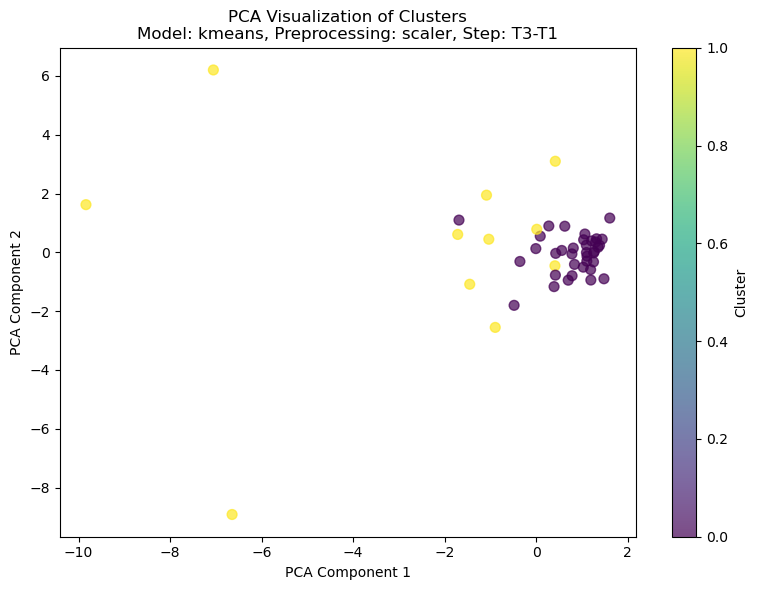


Cluster Summary Statistics:
         Fugl.Meyer_affected_UPPER_EXTREMITY                      \
                                       mean    median       std   
Cluster                                                           
0                                  0.089613  0.260048  0.604437   
1                                 -0.293279  0.260048  1.815977   

        Ashworth_affected                      \
                     mean    median       std   
Cluster                                         
0               -0.086138 -0.289065  1.072821   
1                0.281907  0.581185  0.746702   

        Fugl.Meyer_unaffected_UPPER_EXTREMITY                      \
                                         mean    median       std   
Cluster                                                             
0                                   -0.053659 -0.021579  0.192482   
1                                    0.175613 -0.021579  2.127449   

        Fugl.Meyer_unaffected_WRIST  ...  

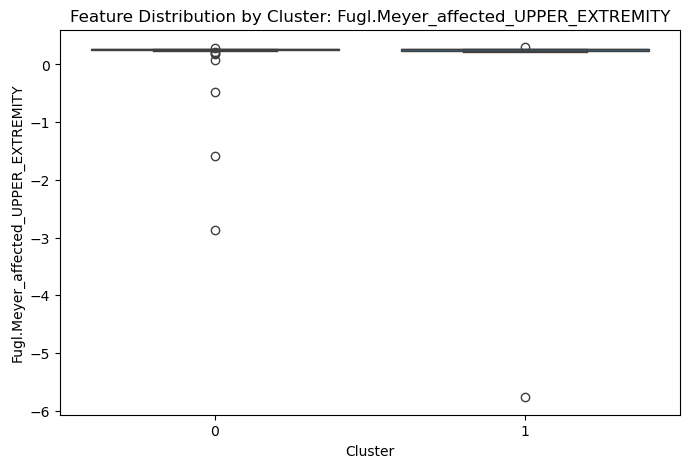

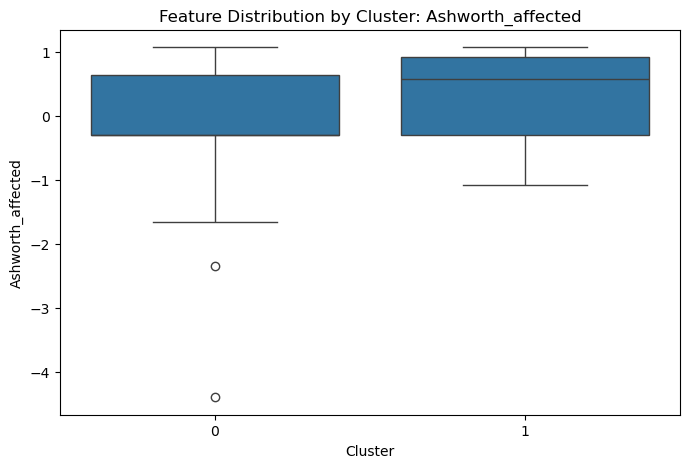

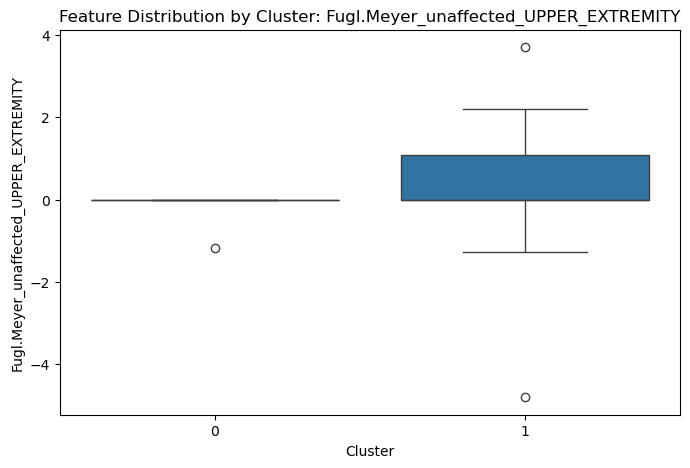

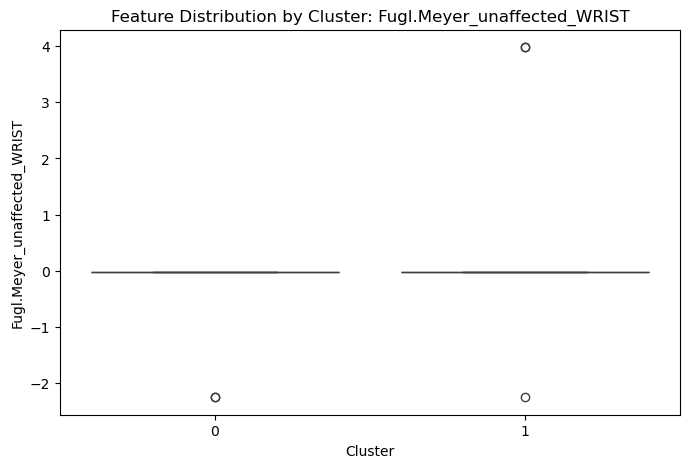

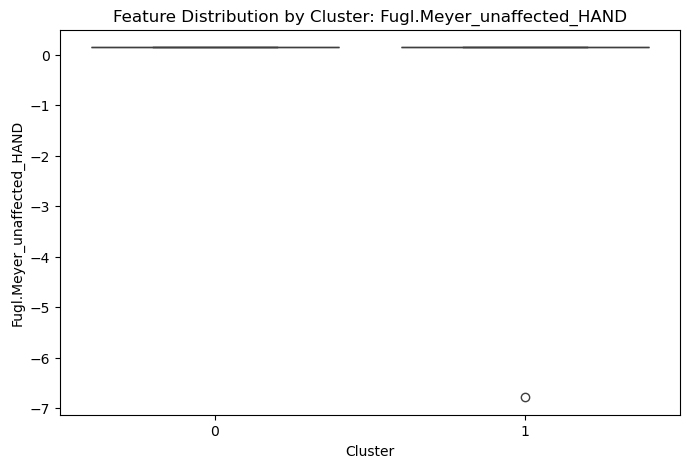

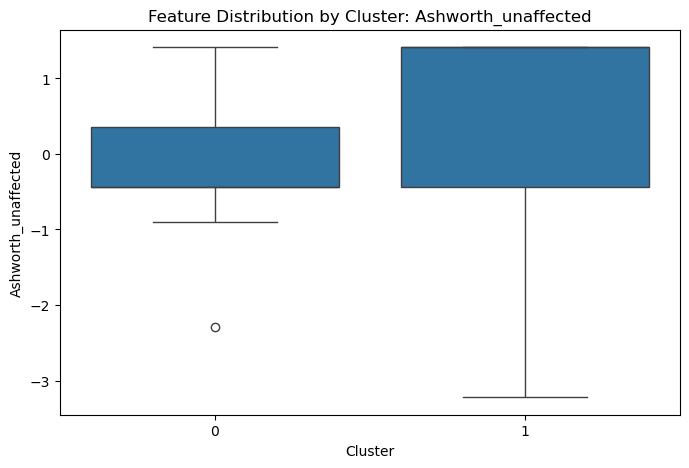

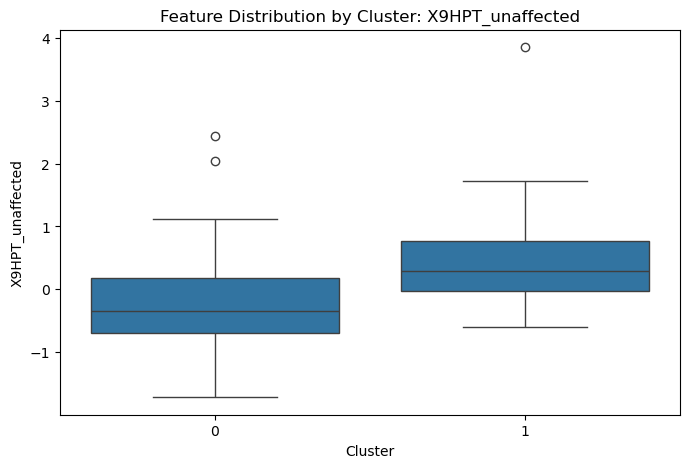

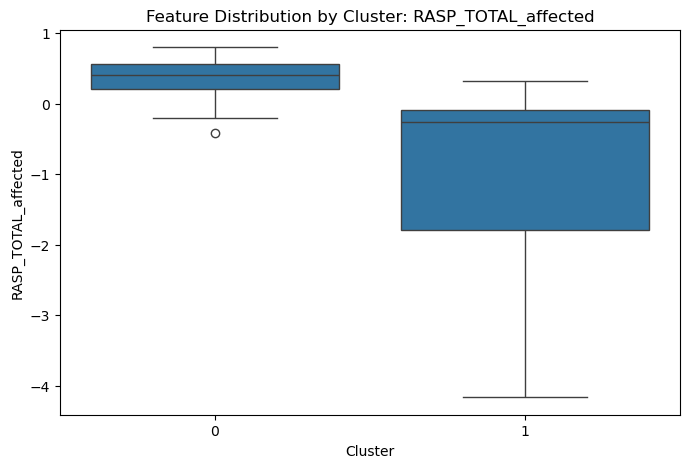

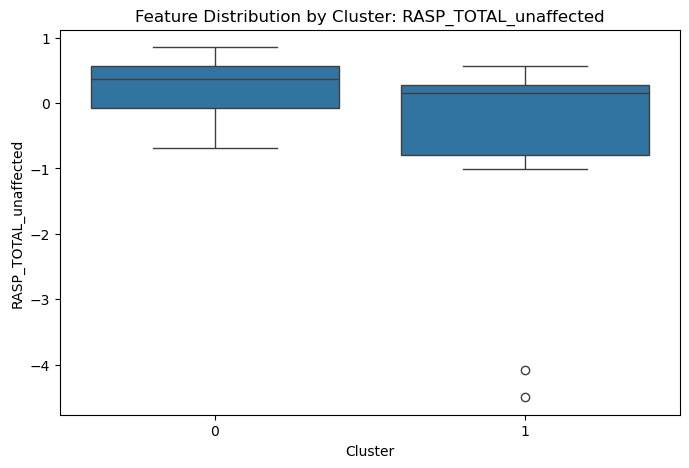

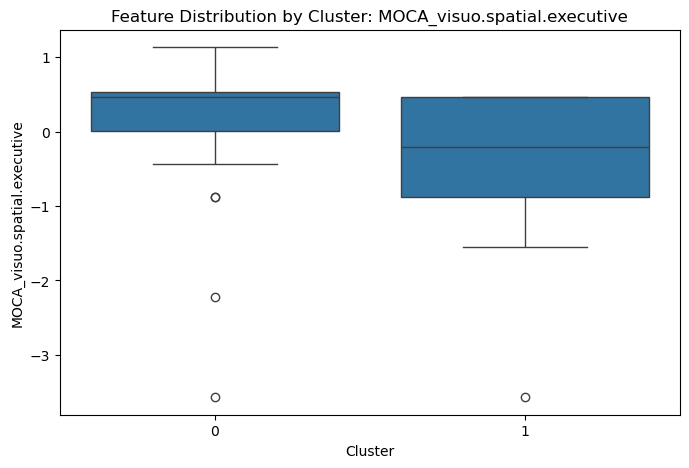

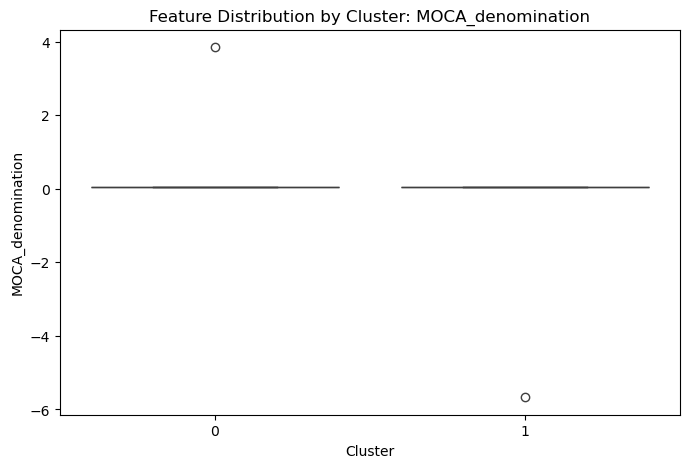

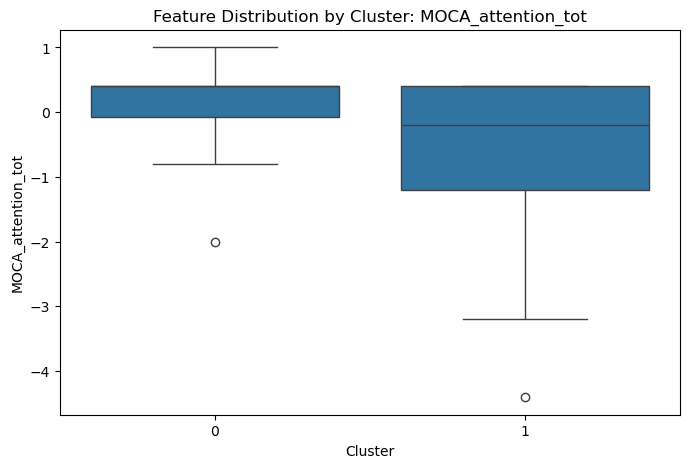

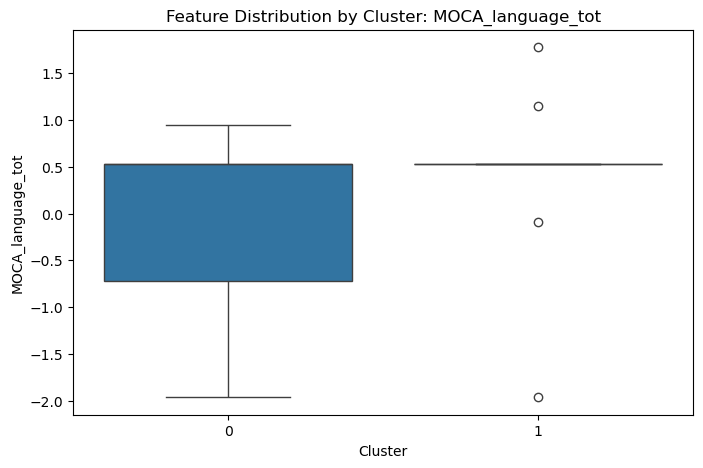

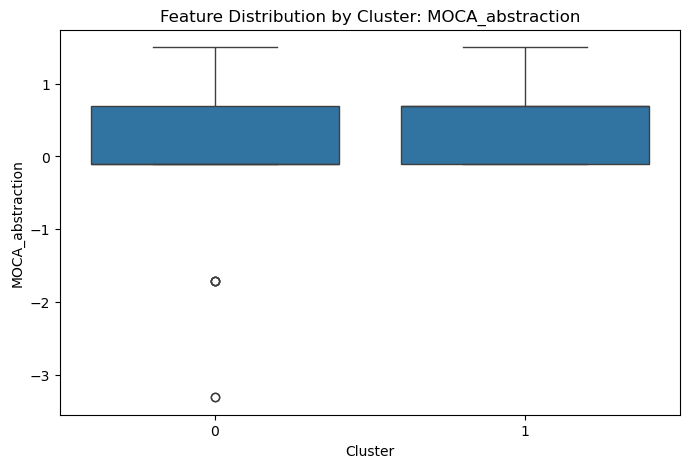

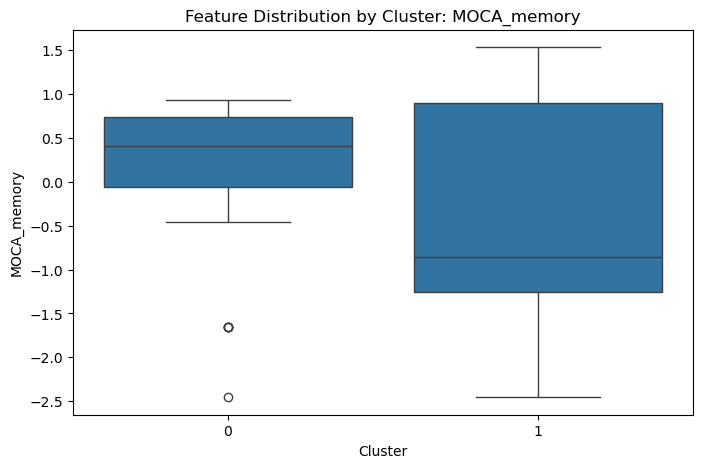

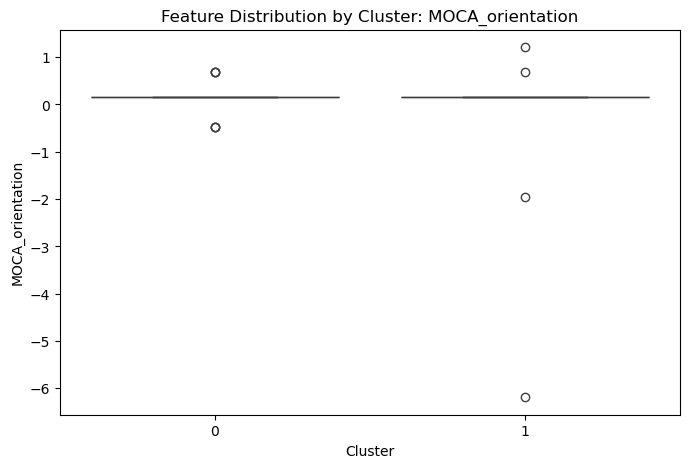

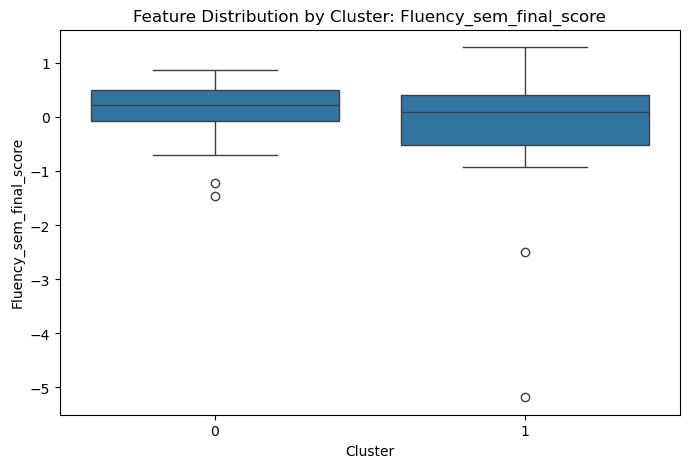

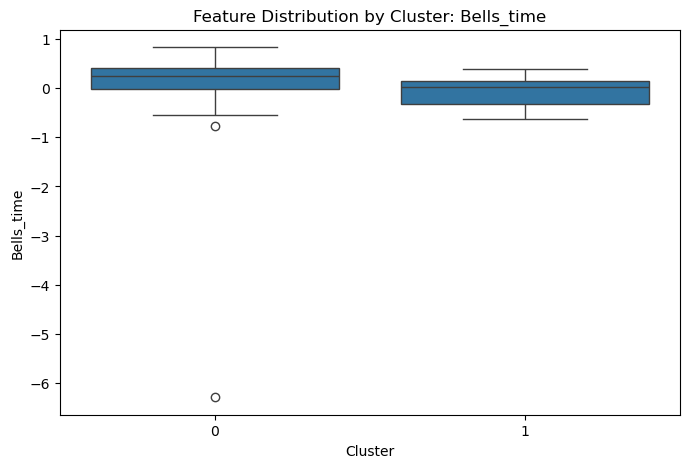

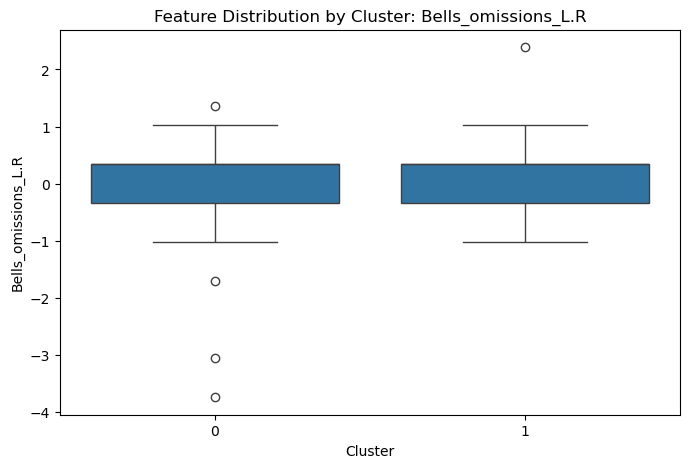

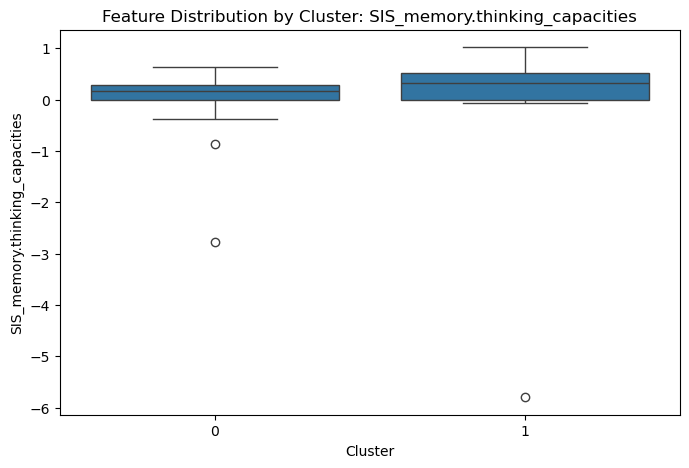

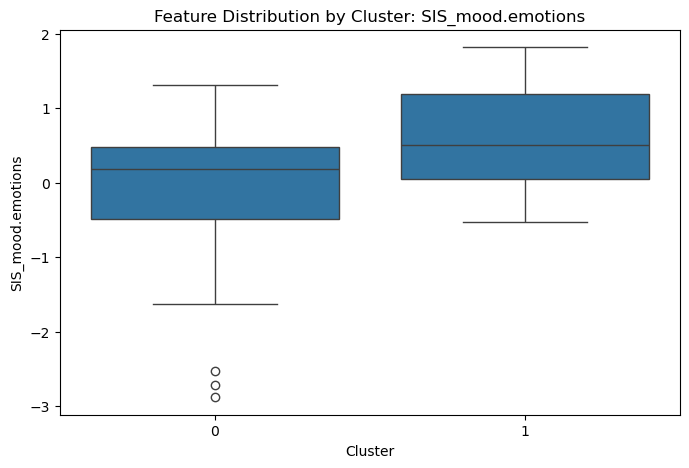

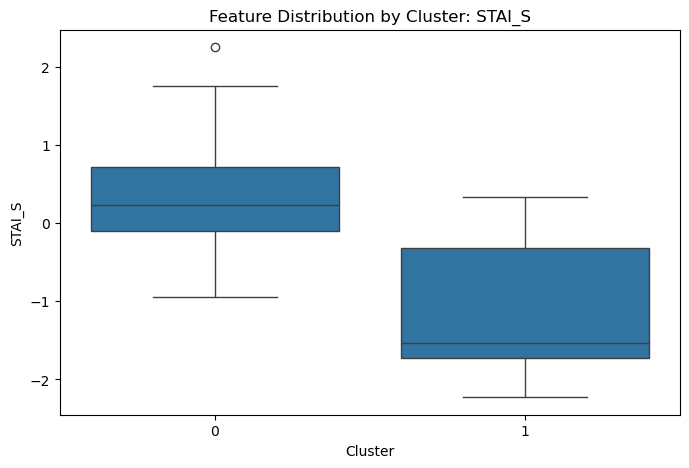

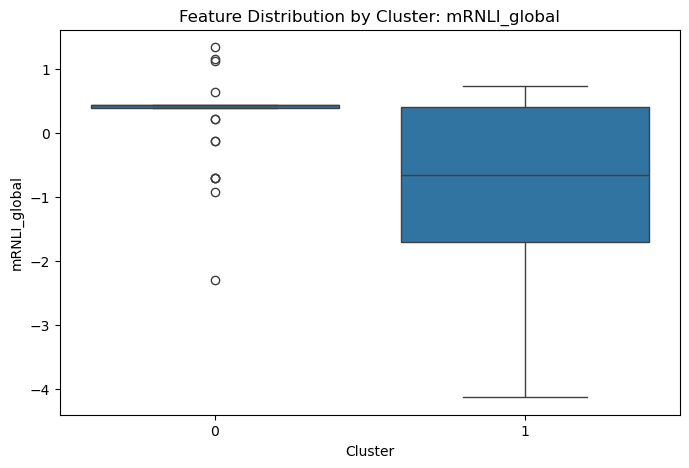

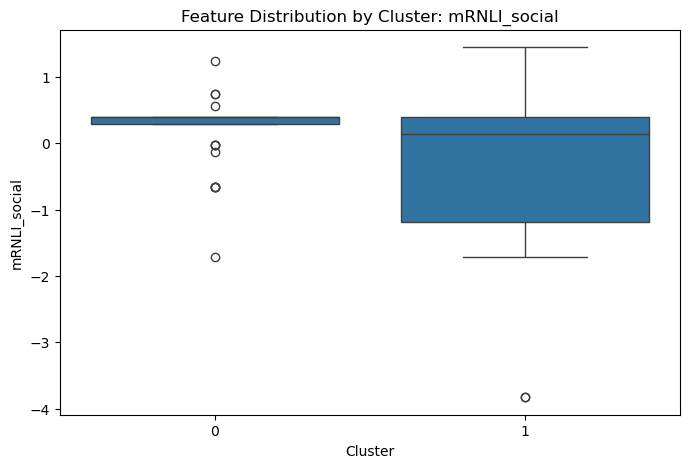

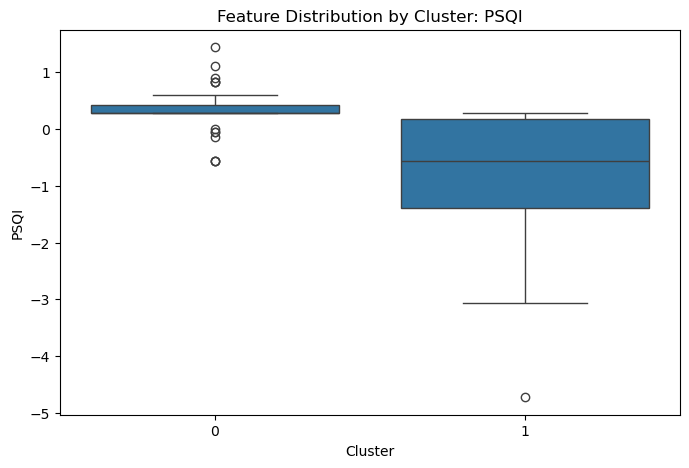

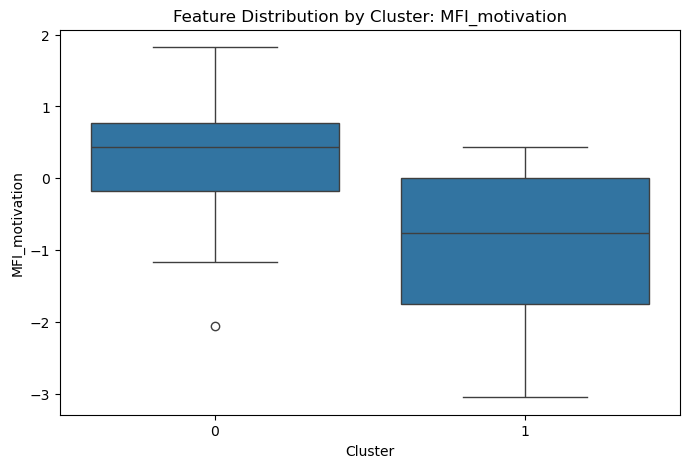

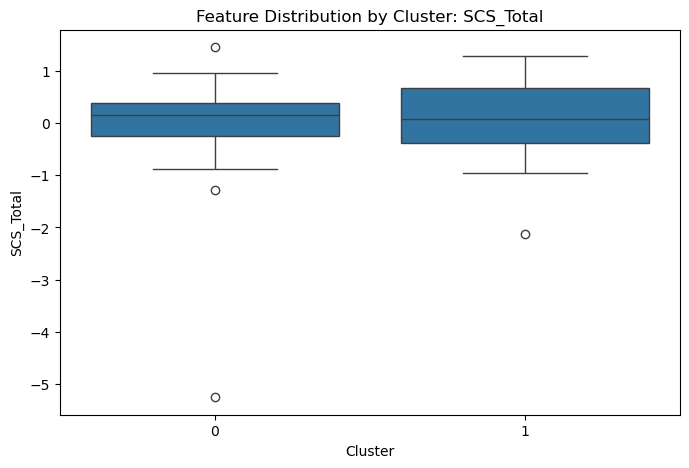

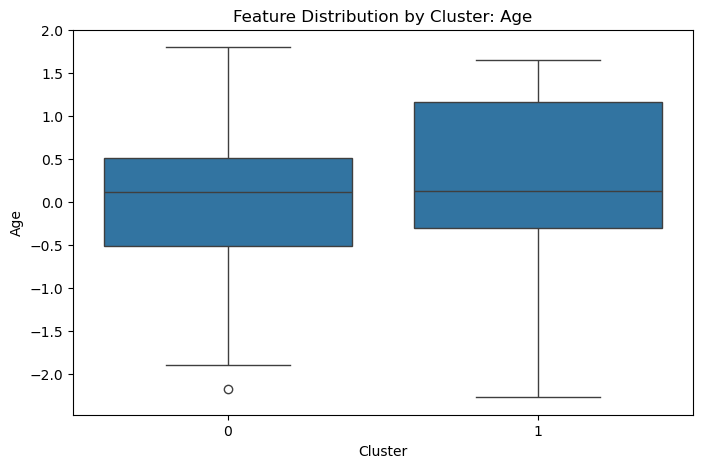

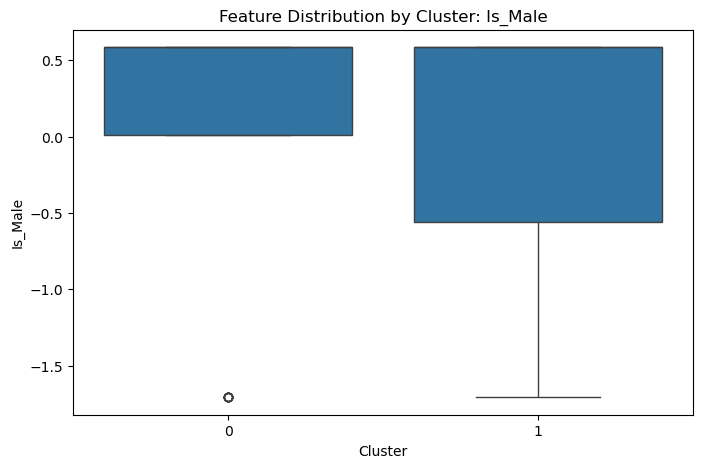

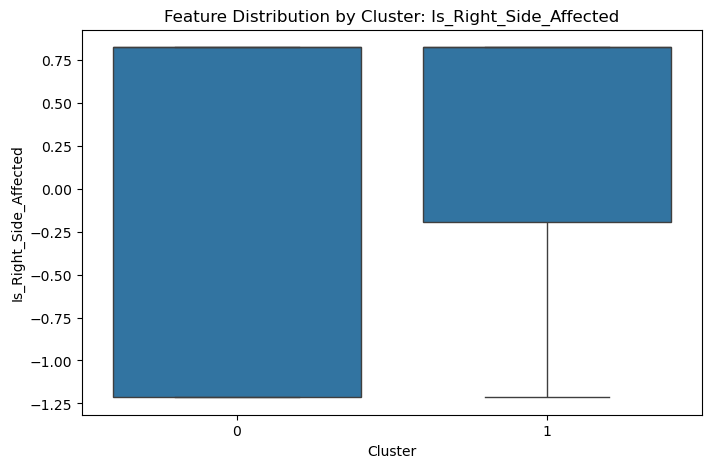

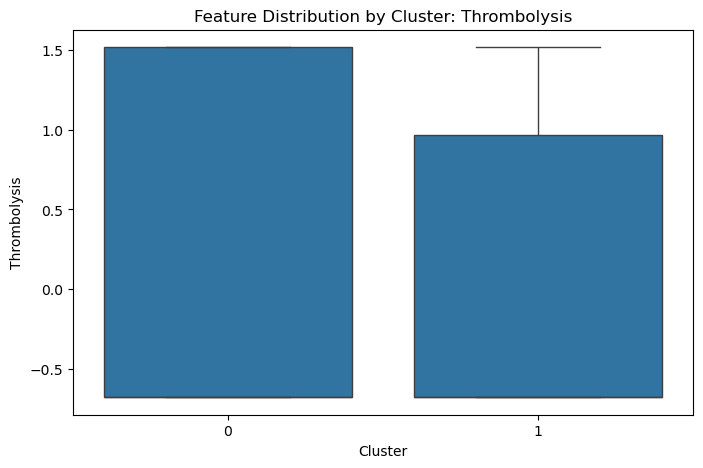

['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashworth_affected', 'Fugl.Meyer_unaffected_UPPER_EXTREMITY', 'Fugl.Meyer_unaffected_WRIST', 'Fugl.Meyer_unaffected_HAND', 'Ashworth_unaffected', 'X9HPT_unaffected', 'RASP_TOTAL_affected', 'RASP_TOTAL_unaffected', 'MOCA_visuo.spatial.executive', 'MOCA_denomination', 'MOCA_attention_tot', 'MOCA_language_tot', 'MOCA_abstraction', 'MOCA_memory', 'MOCA_orientation', 'Fluency_sem_final_score', 'Bells_time', 'Bells_omissions_L.R', 'SIS_memory.thinking_capacities', 'SIS_mood.emotions', 'STAI_S', 'mRNLI_global', 'mRNLI_social', 'PSQI', 'MFI_motivation', 'SCS_Total']
['Age', 'Is_Male', 'Is_Right_Side_Affected', 'Thrombolysis']
{'clusters': array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0]), 'silhouette_score': 0.13975851839202819, 'dbi': 2.2203100100855497, 'ch_score': 7.224608995228734}
['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashworth_affected

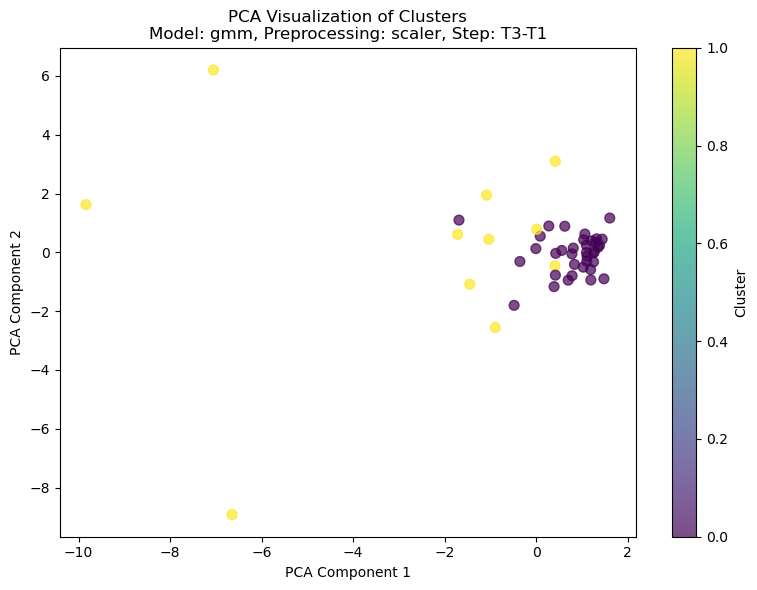


Cluster Summary Statistics:
         Fugl.Meyer_affected_UPPER_EXTREMITY                      \
                                       mean    median       std   
Cluster                                                           
0                                  0.089613  0.260048  0.604437   
1                                 -0.293279  0.260048  1.815977   

        Ashworth_affected                      \
                     mean    median       std   
Cluster                                         
0               -0.086138 -0.289065  1.072821   
1                0.281907  0.581185  0.746702   

        Fugl.Meyer_unaffected_UPPER_EXTREMITY                      \
                                         mean    median       std   
Cluster                                                             
0                                   -0.053659 -0.021579  0.192482   
1                                    0.175613 -0.021579  2.127449   

        Fugl.Meyer_unaffected_WRIST  ...  

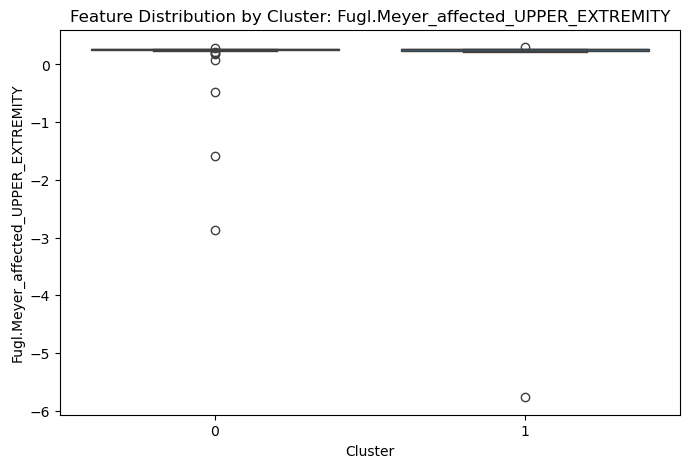

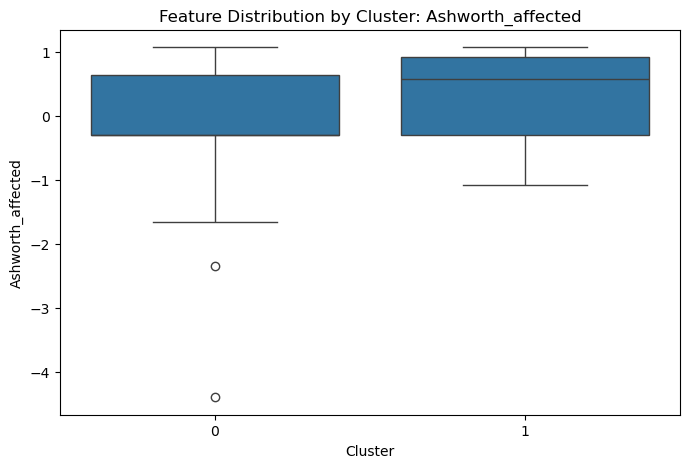

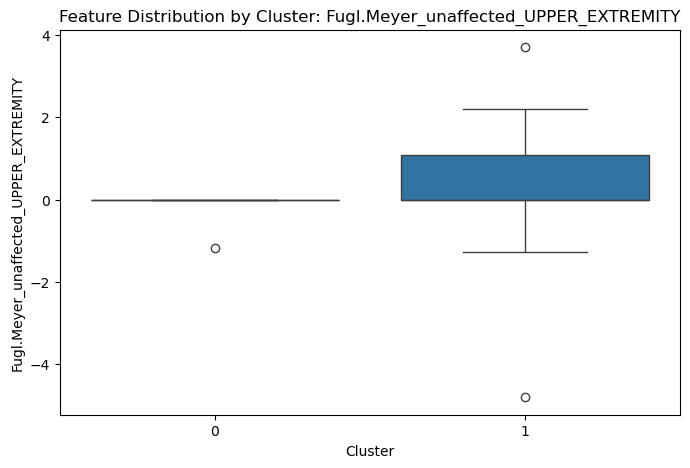

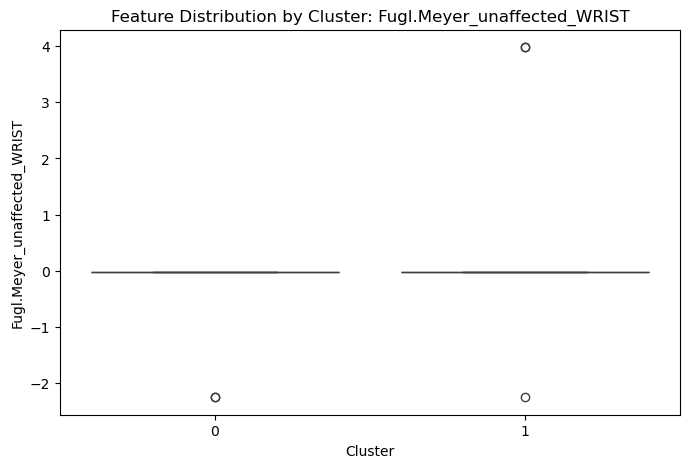

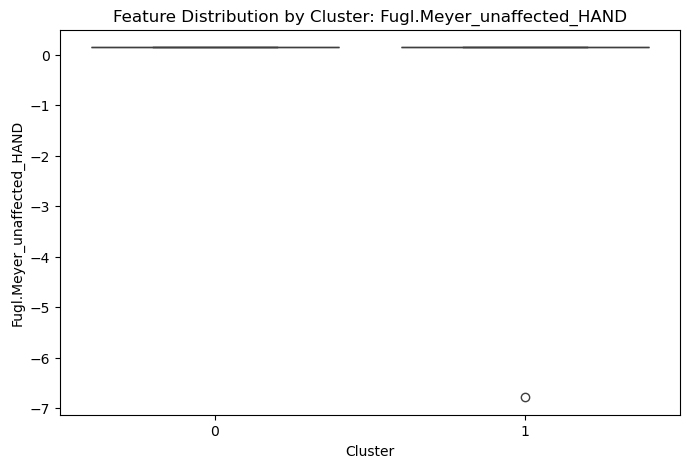

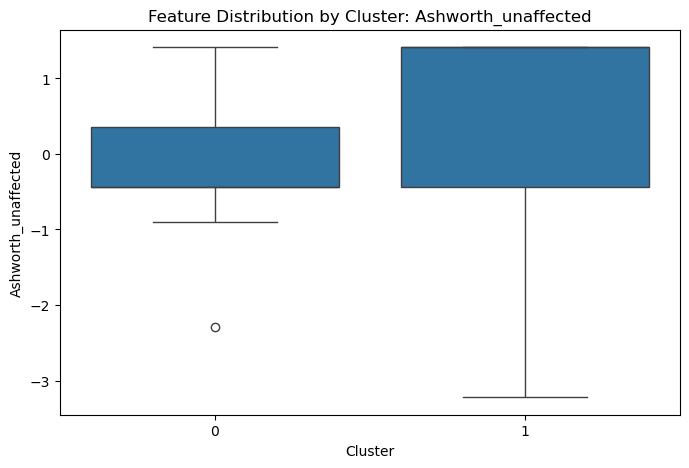

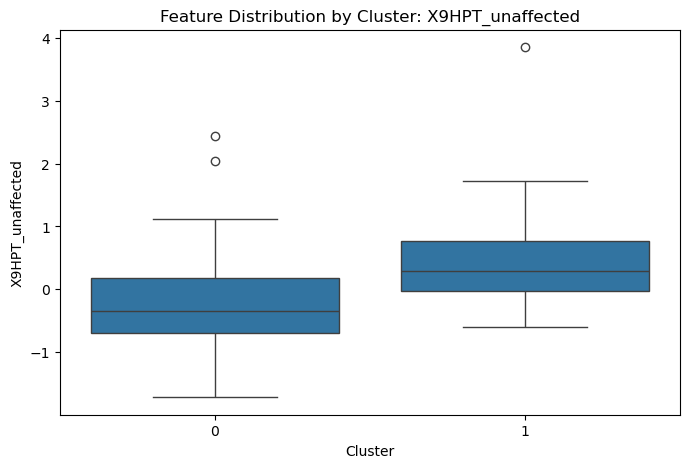

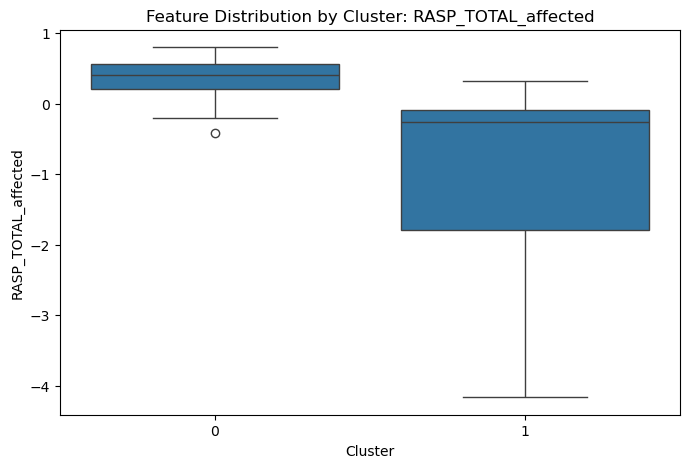

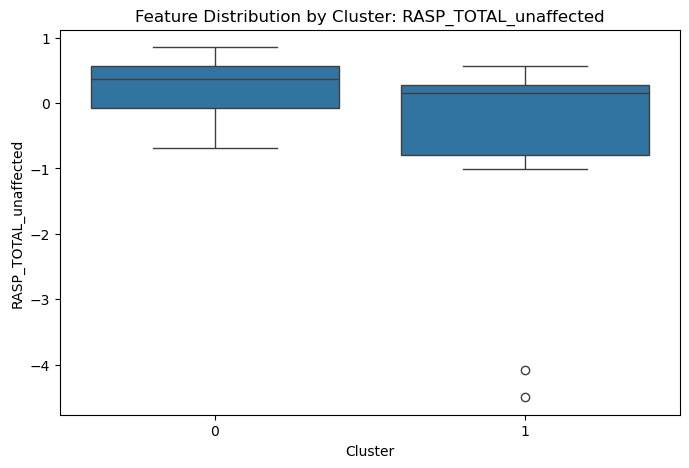

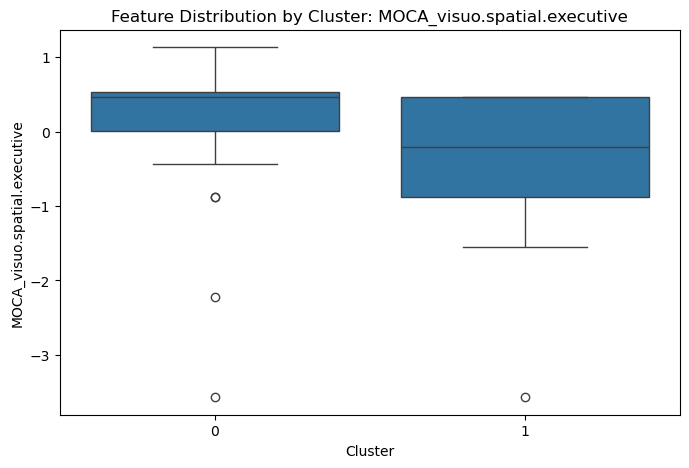

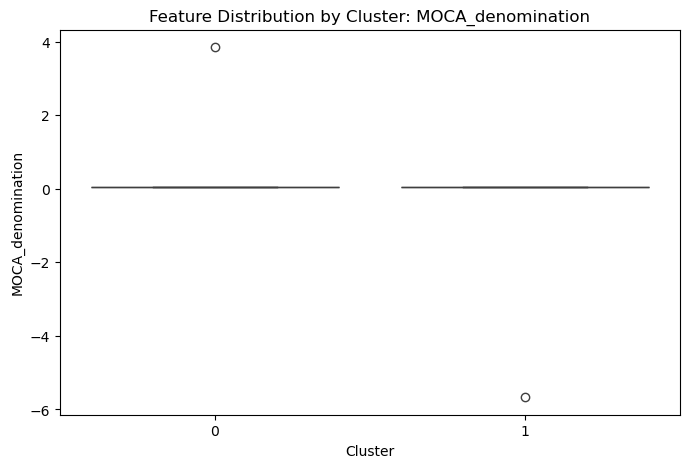

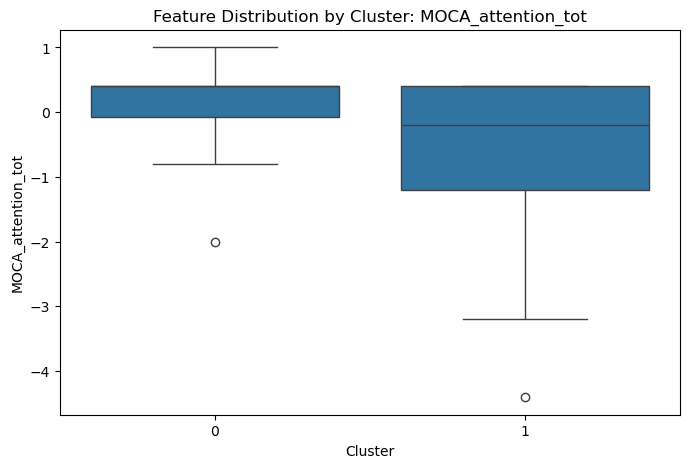

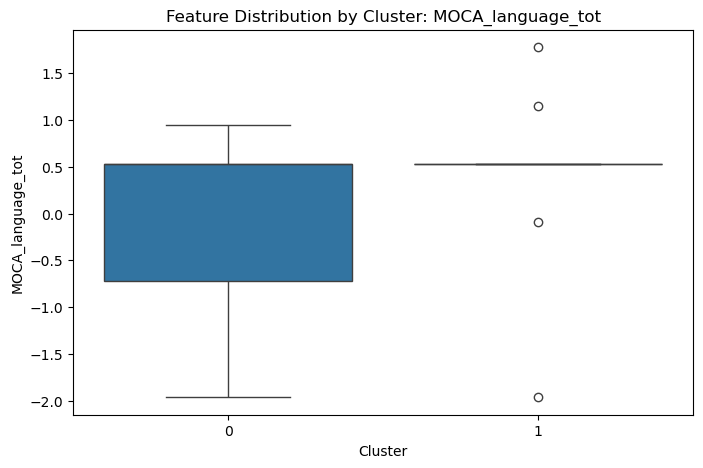

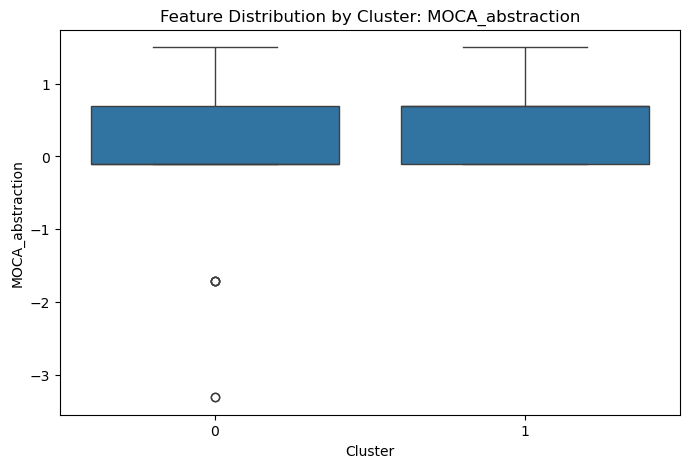

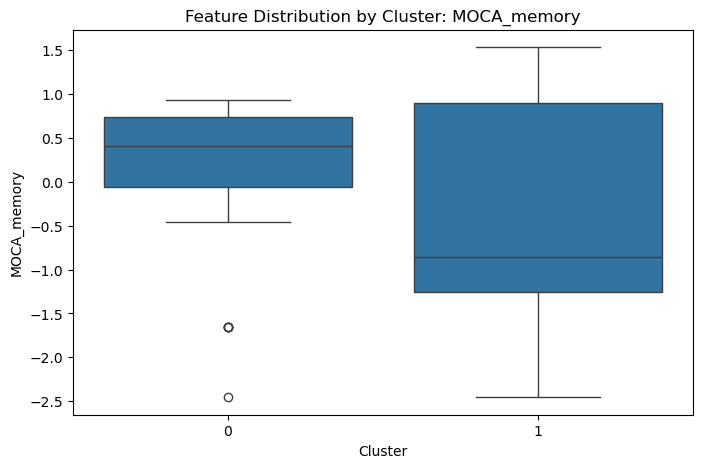

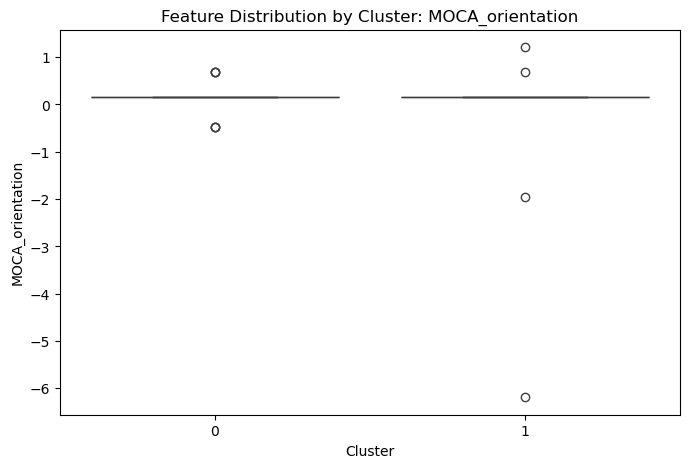

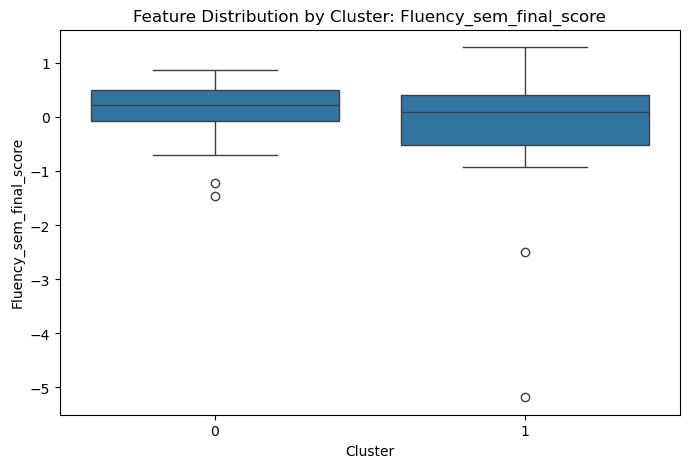

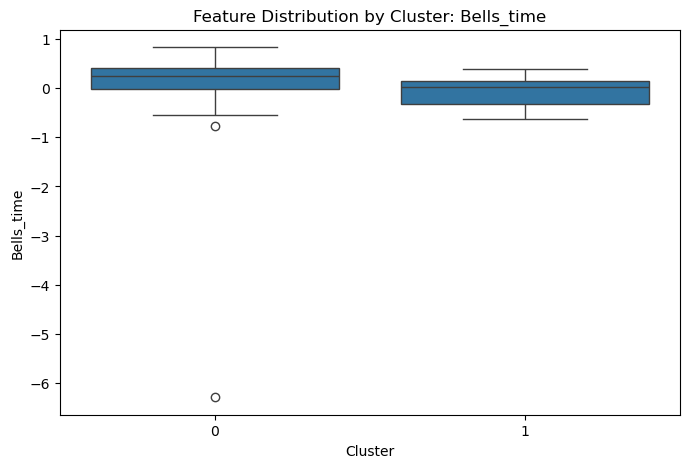

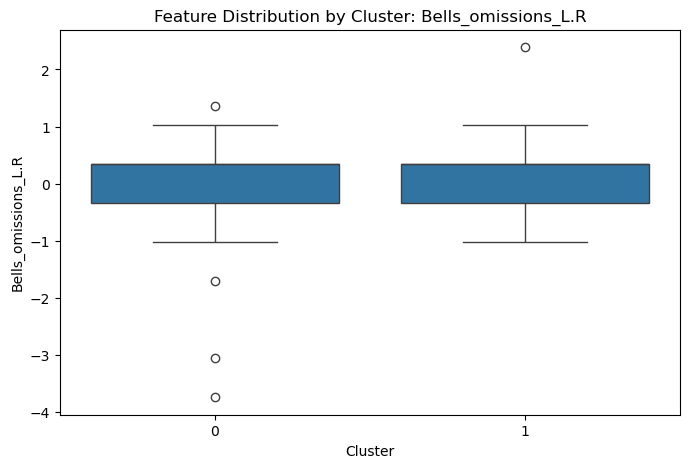

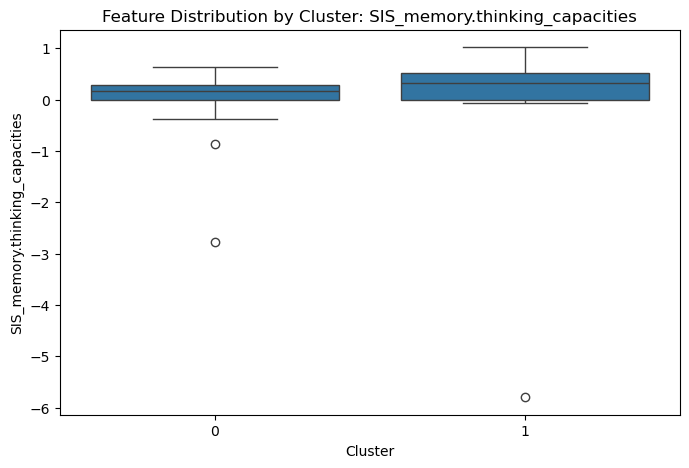

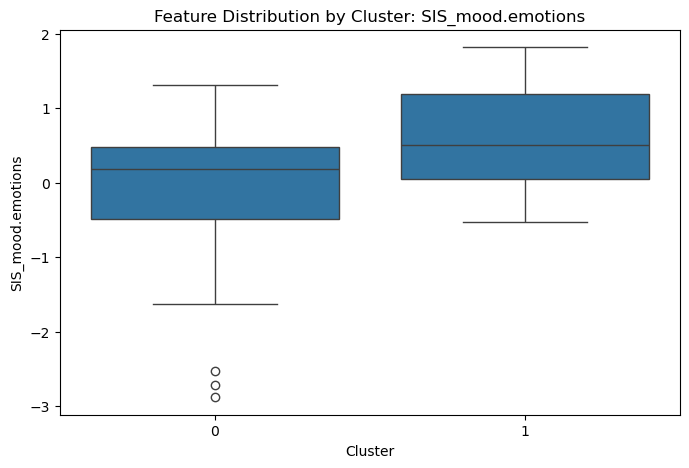

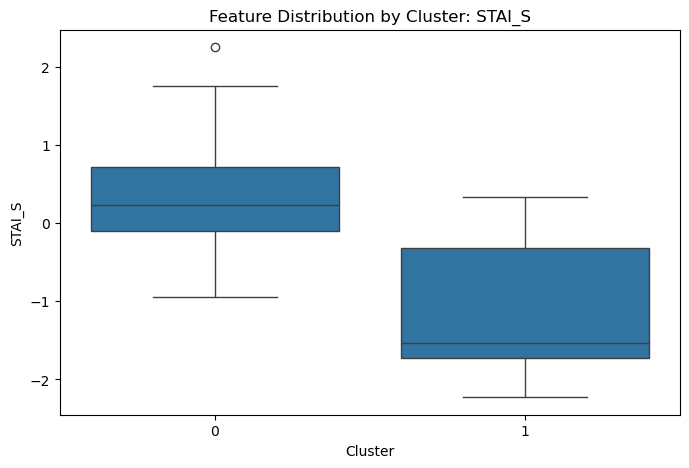

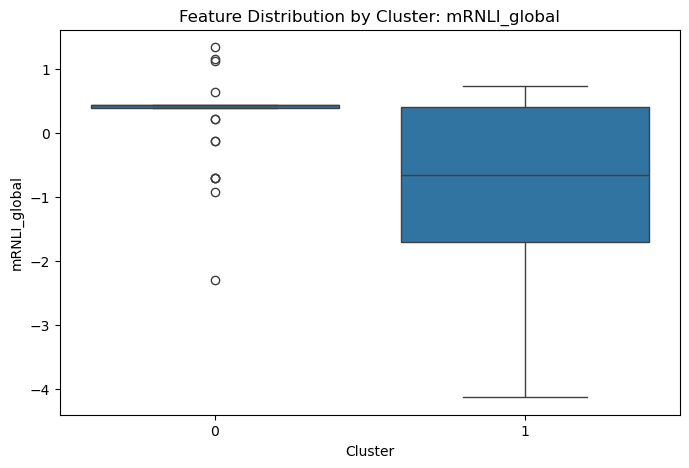

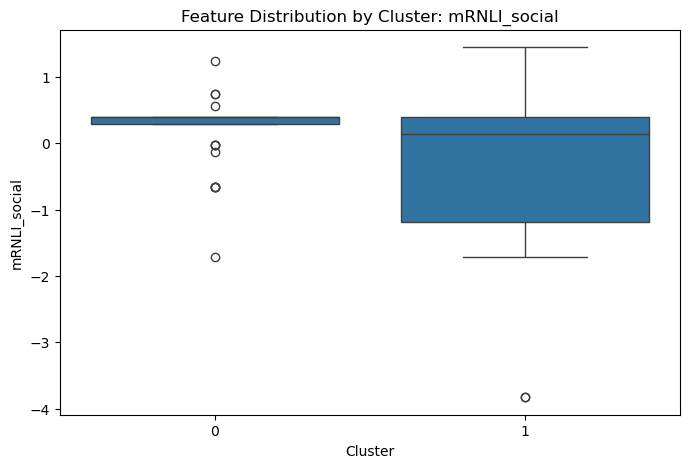

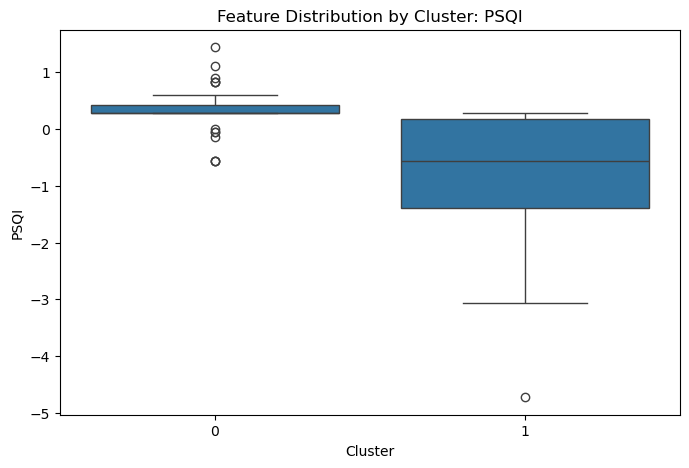

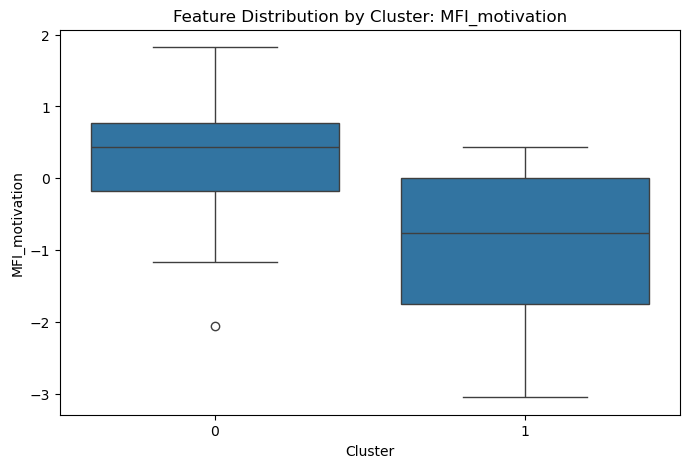

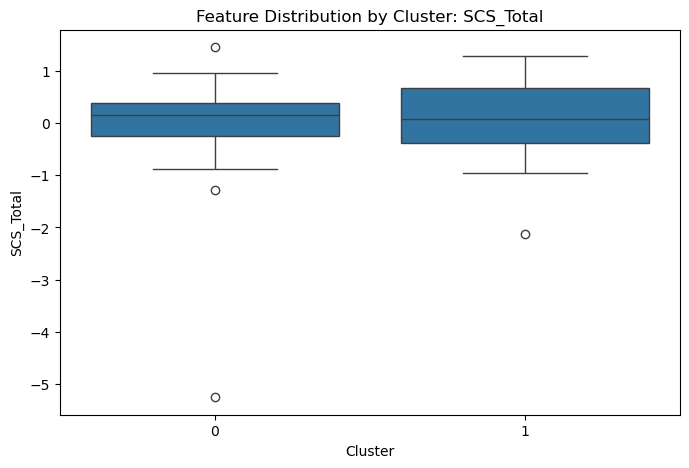

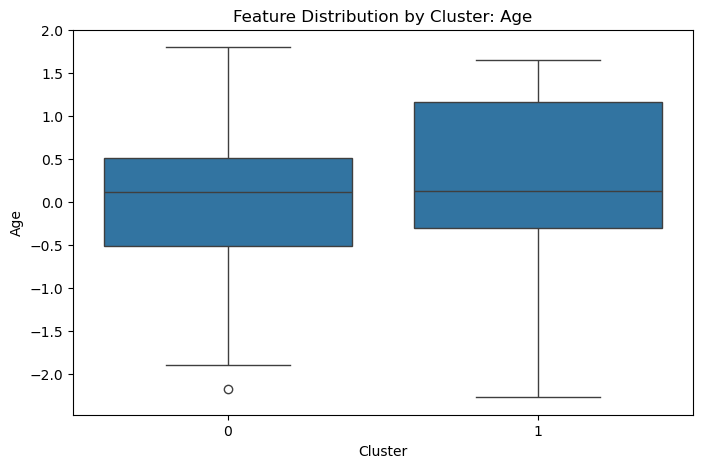

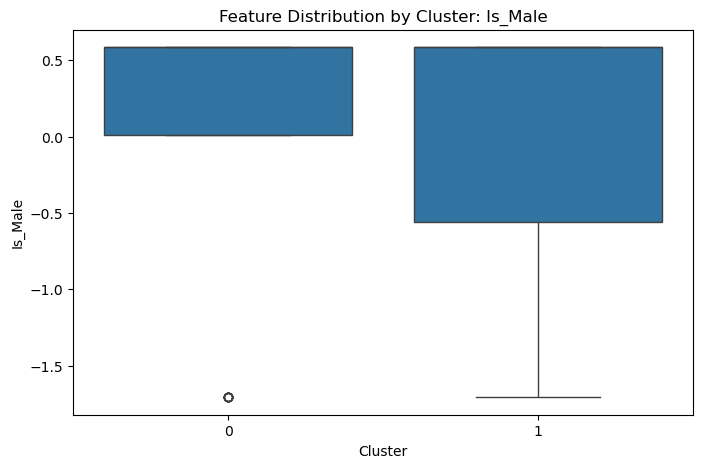

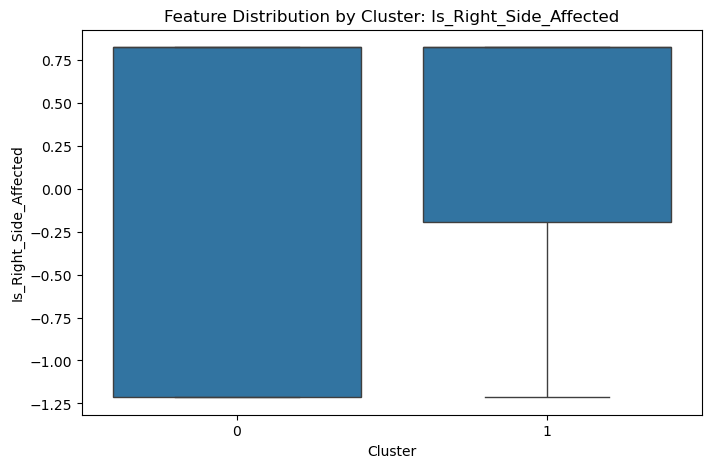

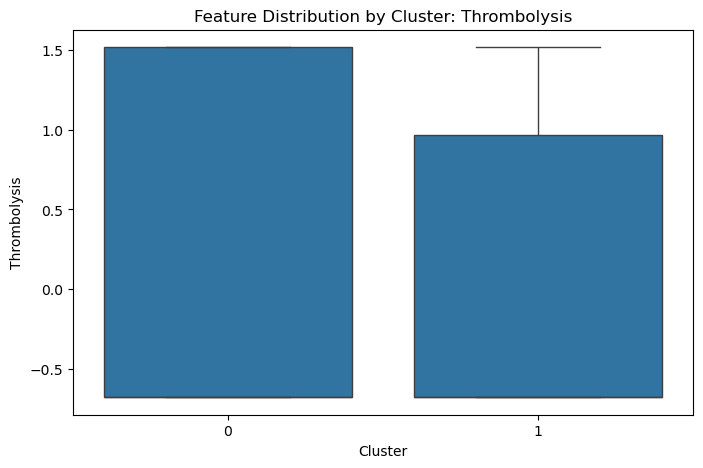

['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashworth_affected', 'Fugl.Meyer_unaffected_UPPER_EXTREMITY', 'Fugl.Meyer_unaffected_WRIST', 'Fugl.Meyer_unaffected_HAND', 'Ashworth_unaffected', 'X9HPT_unaffected', 'RASP_TOTAL_affected', 'RASP_TOTAL_unaffected', 'MOCA_visuo.spatial.executive', 'MOCA_denomination', 'MOCA_attention_tot', 'MOCA_language_tot', 'MOCA_abstraction', 'MOCA_memory', 'MOCA_orientation', 'Fluency_sem_final_score', 'Bells_time', 'Bells_omissions_L.R', 'SIS_memory.thinking_capacities', 'SIS_mood.emotions', 'STAI_S', 'mRNLI_global', 'mRNLI_social', 'PSQI', 'MFI_motivation', 'SCS_Total']
['Age', 'Is_Male', 'Is_Right_Side_Affected', 'Thrombolysis']
{'clusters': array([1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0], dtype=int64), 'silhouette_score': 0.13975851839202819, 'dbi': 2.2203100100855497, 'ch_score': 7.224608995228734}
['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashw

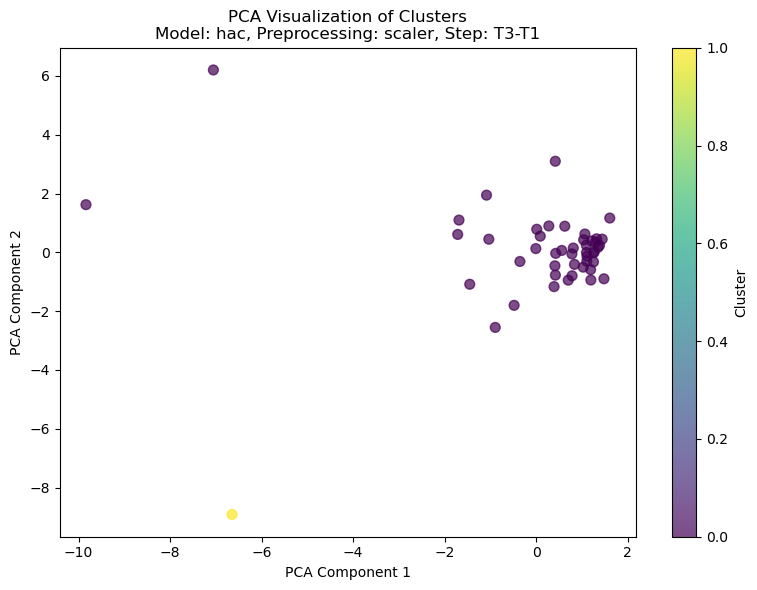


Cluster Summary Statistics:
         Fugl.Meyer_affected_UPPER_EXTREMITY                      \
                                       mean    median       std   
Cluster                                                           
0                                 -0.006493  0.260048  1.020989   
1                                  0.298691  0.298691       NaN   

        Ashworth_affected                      \
                     mean    median       std   
Cluster                                         
0               -0.016839 -0.289065  1.015294   
1                0.774573  0.774573       NaN   

        Fugl.Meyer_unaffected_UPPER_EXTREMITY                      \
                                         mean    median       std   
Cluster                                                             
0                                   -0.048070 -0.021579  0.966141   
1                                    2.211214  2.211214       NaN   

        Fugl.Meyer_unaffected_WRIST  ...  

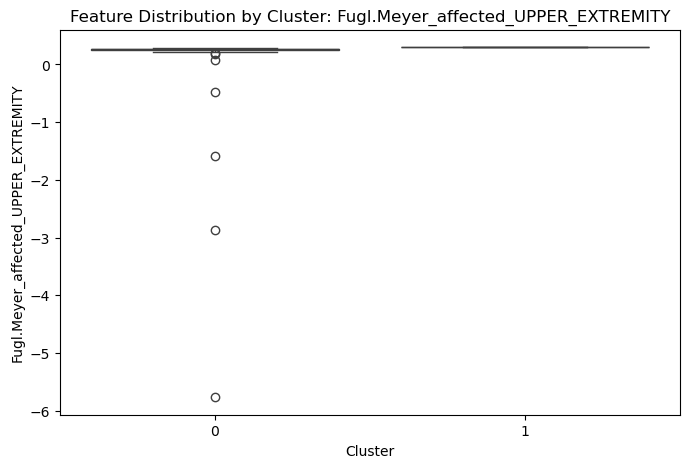

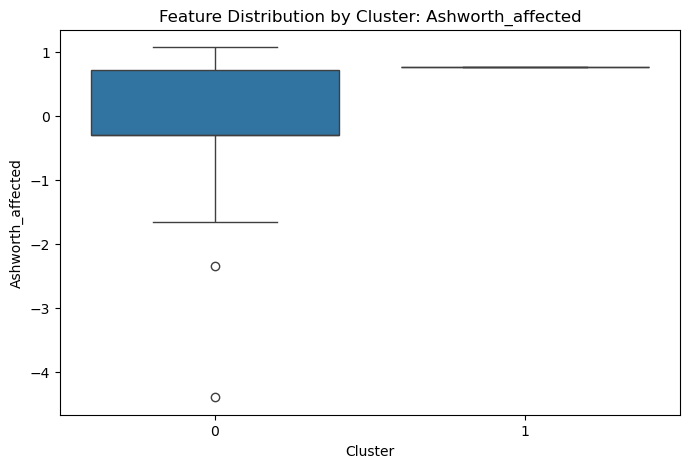

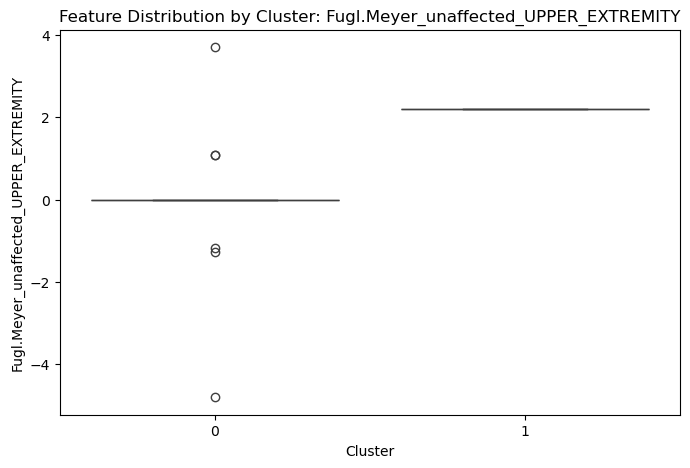

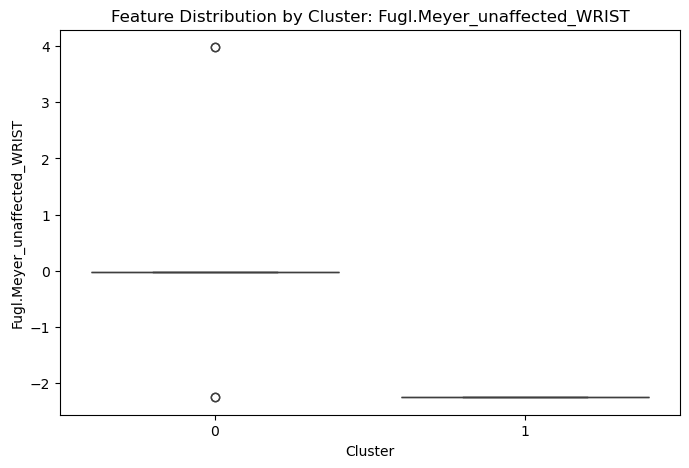

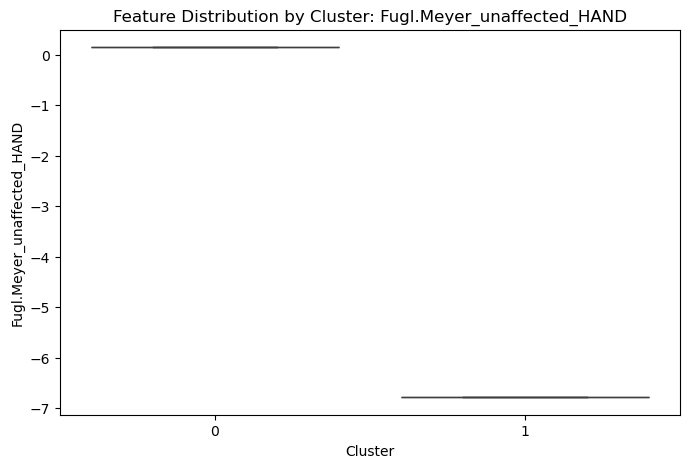

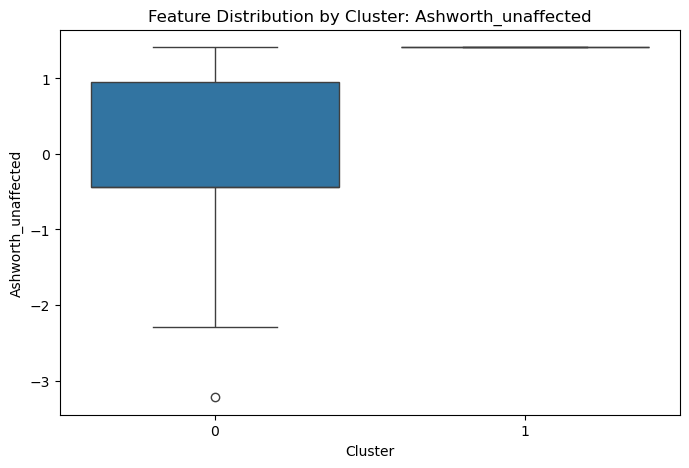

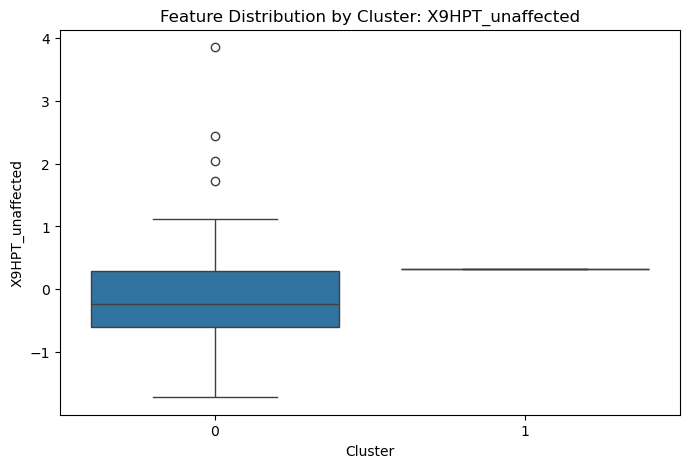

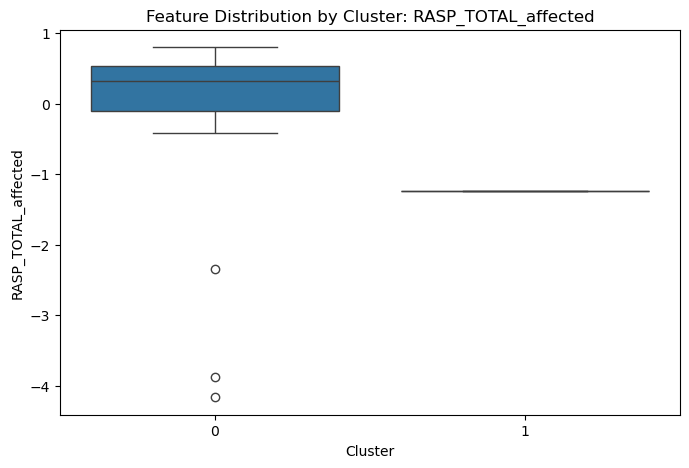

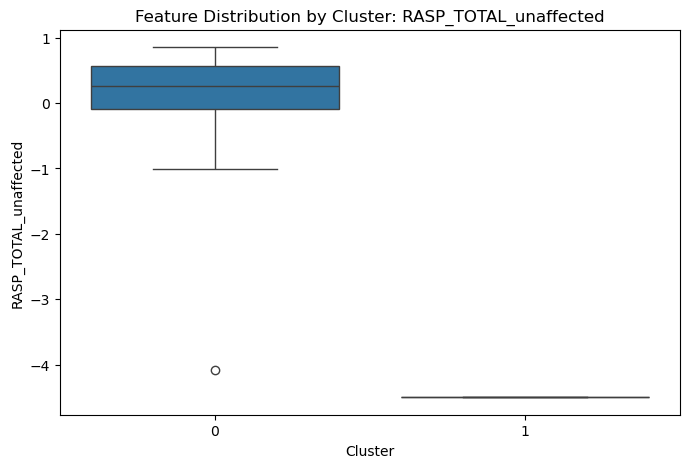

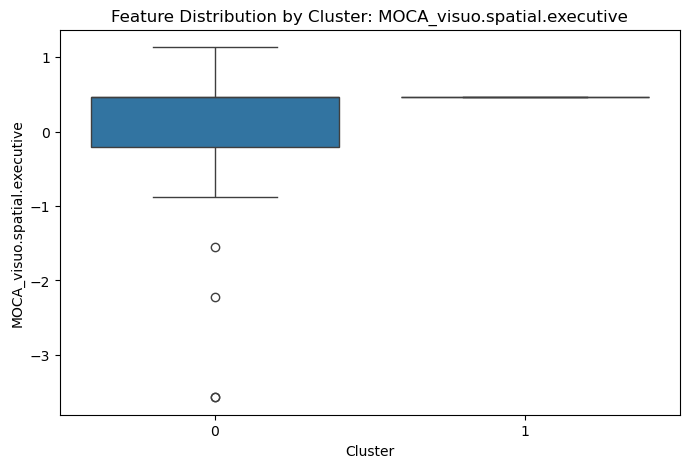

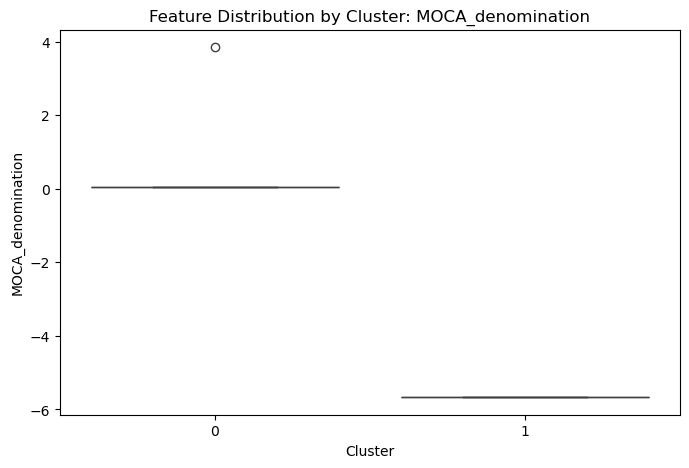

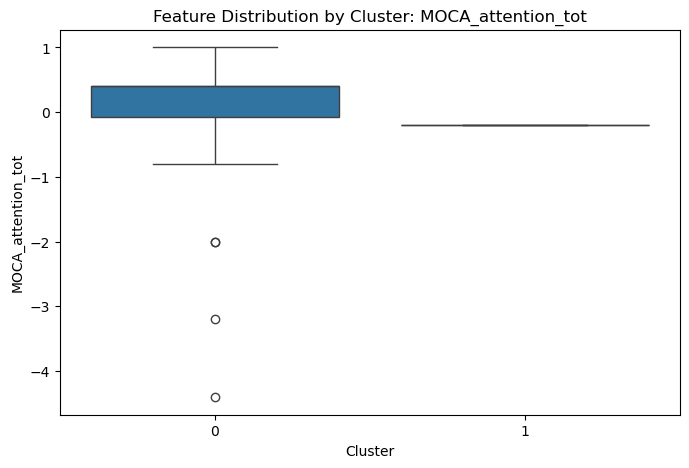

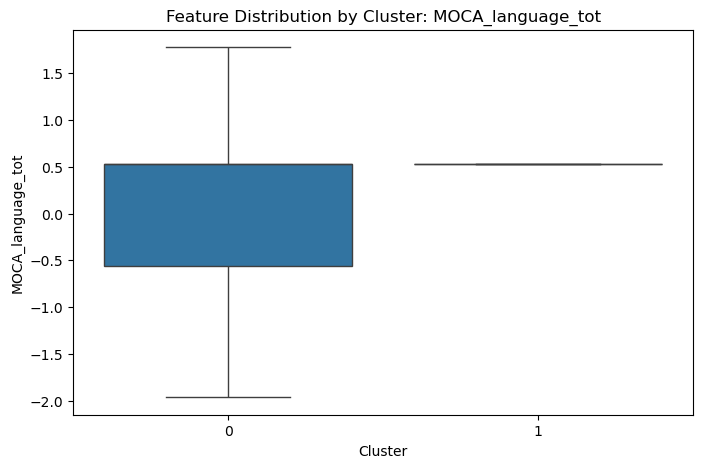

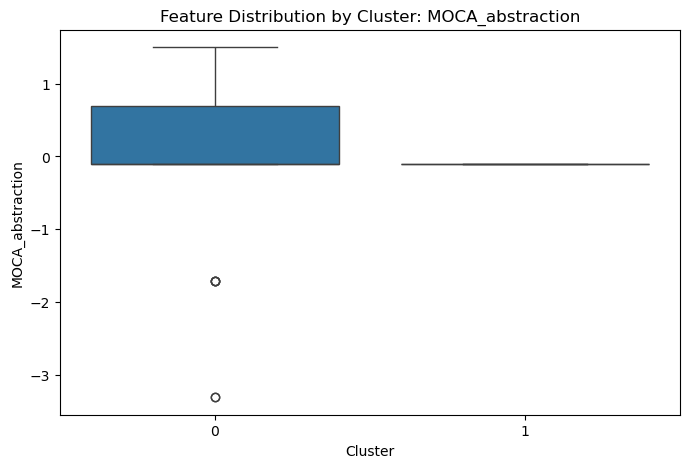

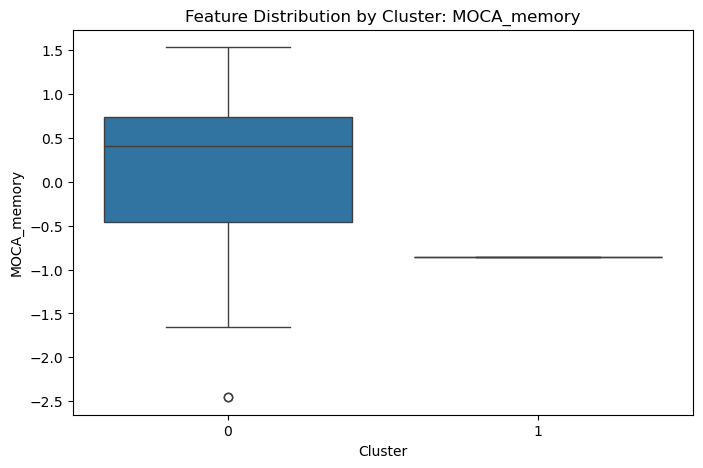

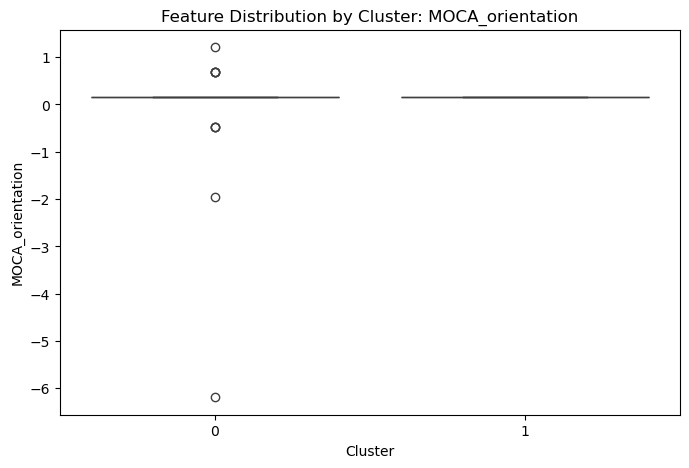

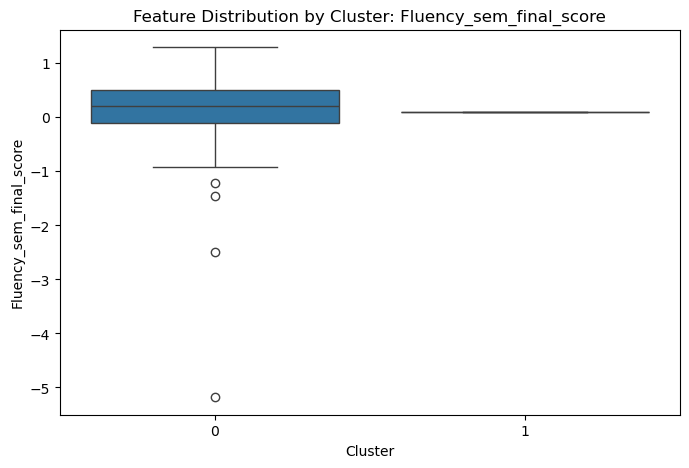

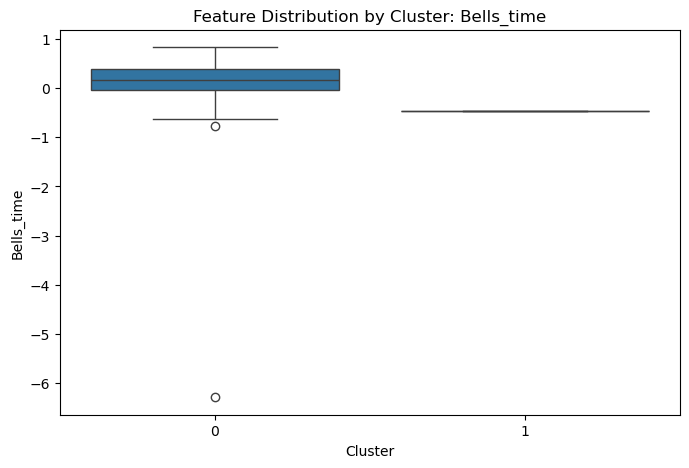

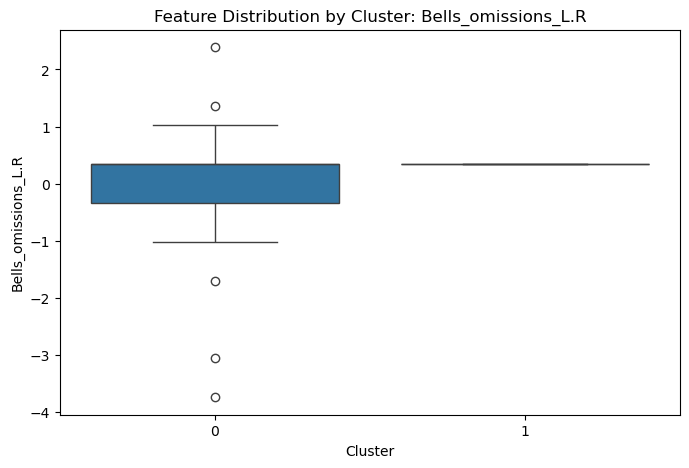

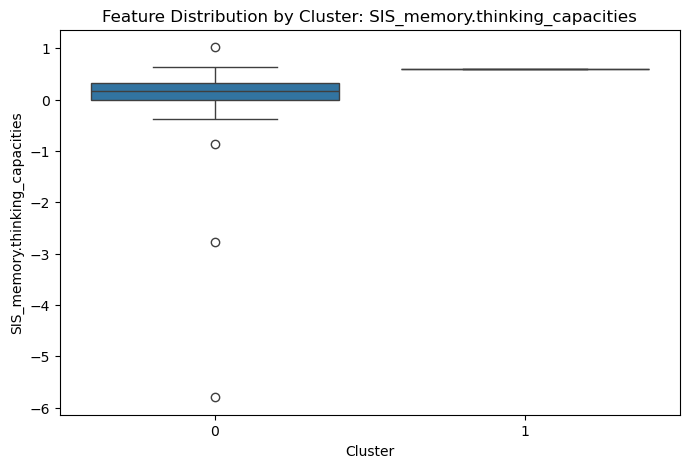

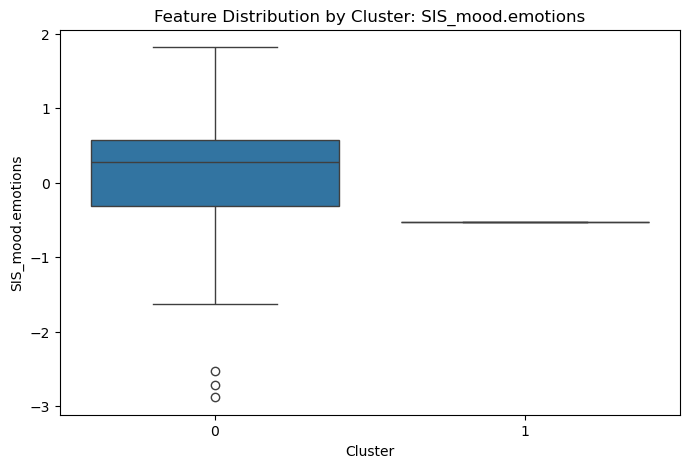

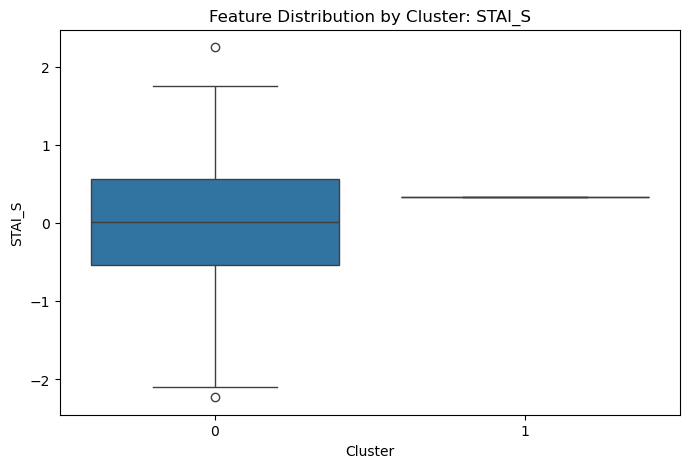

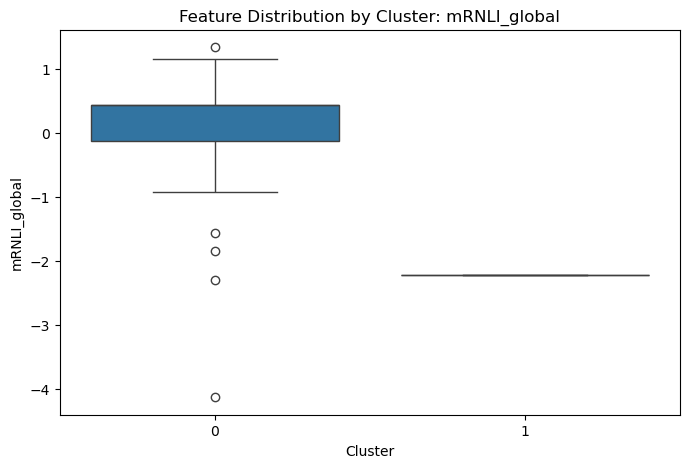

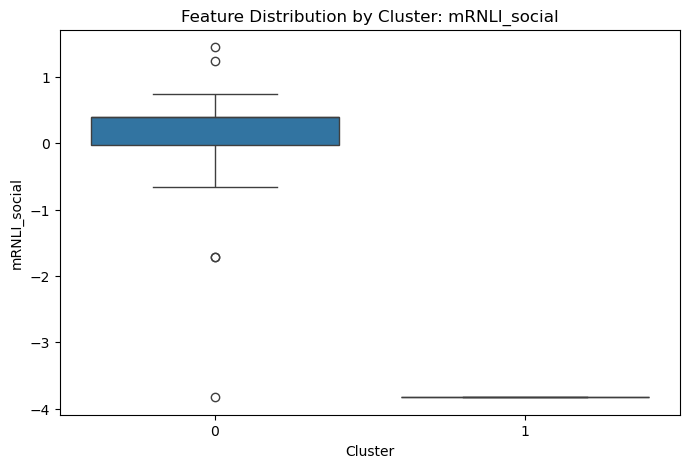

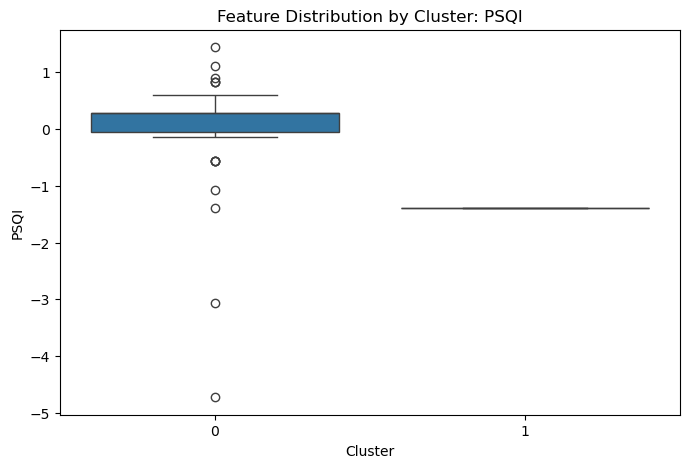

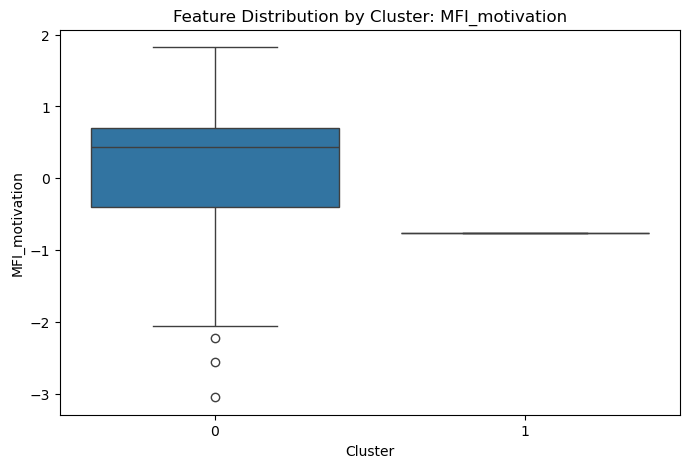

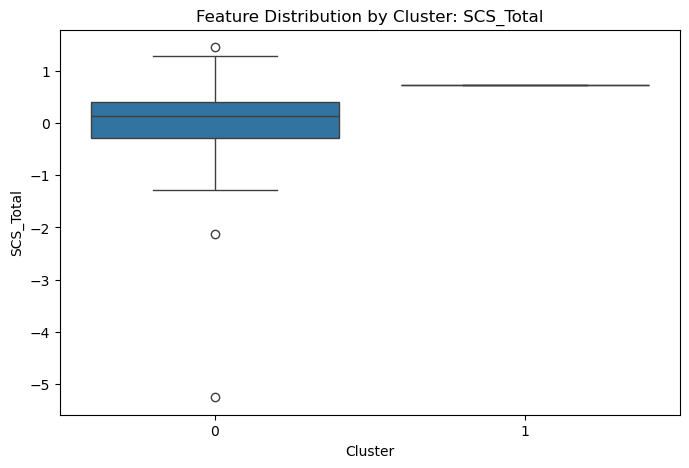

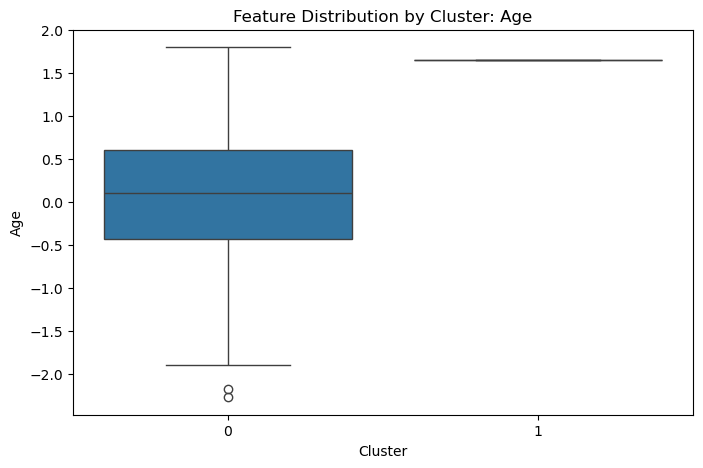

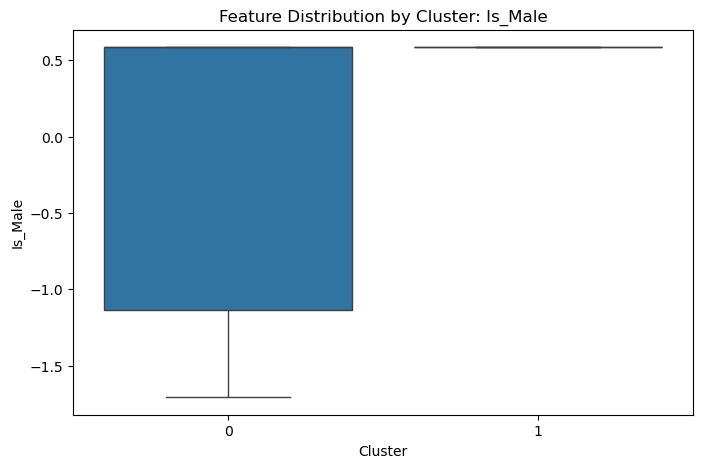

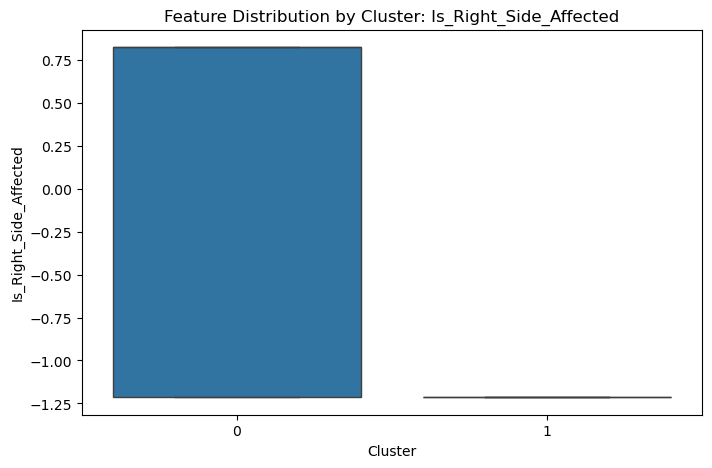

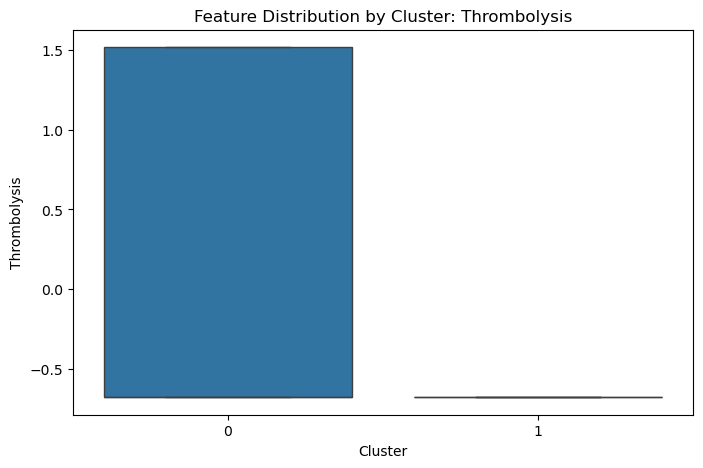

['Fugl.Meyer_affected_UPPER_EXTREMITY', 'Ashworth_affected', 'Fugl.Meyer_unaffected_UPPER_EXTREMITY', 'Fugl.Meyer_unaffected_WRIST', 'Fugl.Meyer_unaffected_HAND', 'Ashworth_unaffected', 'X9HPT_unaffected', 'RASP_TOTAL_affected', 'RASP_TOTAL_unaffected', 'MOCA_visuo.spatial.executive', 'MOCA_denomination', 'MOCA_attention_tot', 'MOCA_language_tot', 'MOCA_abstraction', 'MOCA_memory', 'MOCA_orientation', 'Fluency_sem_final_score', 'Bells_time', 'Bells_omissions_L.R', 'SIS_memory.thinking_capacities', 'SIS_mood.emotions', 'STAI_S', 'mRNLI_global', 'mRNLI_social', 'PSQI', 'MFI_motivation', 'SCS_Total']
['Age', 'Is_Male', 'Is_Right_Side_Affected', 'Thrombolysis']
{'clusters': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0], dtype=int64), 'silhouette_score': 0.1226527095192147, 'dbi': 2.1841274433260955, 'ch_score': 4.754675990836712}


In [31]:
#Modular approach: possibility to choose the categories of features for the clustering 

use_connectomes_features = True #pour utiliser les connectomes
use_general_features = True  
if len(df_T1_corr.columns)>len(df_T3_corr.columns):
    features=df_T3_corr.drop(columns="Patient").columns.tolist()
else:
    features=df_T1_corr.drop(columns="Patient").columns.tolist()
#Au début j'ai utilisé les features en gras de la data sur la réduction de dimensions, 
# mais bon pas ouf les résultats
#features=motor_features#+attention_features+executive_features+memory_features+sensory_features+language_features+neglect_features

results,summary = main_temporal_pipeline(df_T1, df_T3, df_general_final, features, general_features, 
                                 algorithms, params, preprocesses, "T3-T1", 
                                 paths_connectomes,
                                 use_general_features=use_general_features,
                                 use_connectomes_features=use_connectomes_features,)



In [ ]:
summary

[        Fugl.Meyer_affected_UPPER_EXTREMITY                      \
                                        mean    median       std   
 Cluster                                                           
 0                                  0.089613  0.260048  0.604437   
 1                                 -0.293279  0.260048  1.815977   
 
         Ashworth_affected                      \
                      mean    median       std   
 Cluster                                         
 0               -0.086138 -0.289065  1.072821   
 1                0.281907  0.581185  0.746702   
 
         Fugl.Meyer_unaffected_UPPER_EXTREMITY                      \
                                          mean    median       std   
 Cluster                                                             
 0                                   -0.053659 -0.021579  0.192482   
 1                                    0.175613 -0.021579  2.127449   
 
         Fugl.Meyer_unaffected_WRIST  ...       Age   

# donne la liste des meilleurs features


In [ ]:
import pandas as pd
import numpy as np

# Example data: Replace `summary` with your actual cluster summary DataFrame
cluster_summary = summary[3]

# Flatten the multi-index columns into strings if they are tuples
if isinstance(cluster_summary.columns, pd.MultiIndex):
    cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns]

# Extract mean and std columns for each feature
mean_columns = [col for col in cluster_summary.columns if "_mean" in col]
std_columns = [col.replace("_mean", "_std") for col in mean_columns]
# Calculate normalized (Z-score) differences for each feature
differences = {}
for mean_col, std_col in zip(mean_columns, std_columns):
    feature_name = mean_col.replace("_mean", "")
    
    # Mean difference between the two clusters
    mean_diff = abs(cluster_summary.loc[0, mean_col] - cluster_summary.loc[1, mean_col])
    # Pooled standard deviation
    pooled_std = np.sqrt(
        (cluster_summary.loc[0, std_col] ** 2 + cluster_summary.loc[1, std_col] ** 2) / 2
    )

    # Check if pooled_std is valid and avoid division by zero or NaN
    if np.isnan(pooled_std) or pooled_std == 0:
        z_score = 0  # Assign zero if pooled_std is NaN or zero
    else:
        z_score = mean_diff / pooled_std
    
    differences[feature_name] = z_score

# Rank features by Z-score differences
sorted_features = sorted(differences.items(), key=lambda x: x[1], reverse=True)[:15]

# Print the ranked features
print("Top 15 Features Showing the Most Difference Between Clusters:")
for feature, zscore in sorted_features:
    print(f"{feature}: Z-score difference = {zscore:.5f}")


Top 15 Features Showing the Most Difference Between Clusters:
Fugl.Meyer_affected_UPPER_EXTREMITY: Z-score difference = 0.00000
Ashworth_affected: Z-score difference = 0.00000
Fugl.Meyer_unaffected_UPPER_EXTREMITY: Z-score difference = 0.00000
Fugl.Meyer_unaffected_WRIST: Z-score difference = 0.00000
Fugl.Meyer_unaffected_HAND: Z-score difference = 0.00000
Ashworth_unaffected: Z-score difference = 0.00000
X9HPT_unaffected: Z-score difference = 0.00000
RASP_TOTAL_affected: Z-score difference = 0.00000
RASP_TOTAL_unaffected: Z-score difference = 0.00000
MOCA_visuo.spatial.executive: Z-score difference = 0.00000
MOCA_denomination: Z-score difference = 0.00000
MOCA_attention_tot: Z-score difference = 0.00000
MOCA_language_tot: Z-score difference = 0.00000
MOCA_abstraction: Z-score difference = 0.00000
MOCA_memory: Z-score difference = 0.00000


- data vrmt imblanced, possibilité d'utiliser SMOTE
- regarder les graph et s'occuper des skewed distributions
- on peut changer le threshold de la corr matrix + les features connectomes ou non + les features généraux ou non+
le nbr de clusters (2 était tjs le mieux pour moi), les params des modèles, le % de variance que le PCA garde
- ultra sensible aux changements des hyper paramètres :(